### Noise calculations for paper revisions


This notebook explores the model training noise as requested during the first round of paper review.

We use the conda environment `analysis`


#### Define some useful functions

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #Ignore SettingWithCopyWarning - we are safe here

def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())

    
    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 
    
    
    
    
    
    return df,df_grouped



def surface_noise_numbers(df):
    
 
    
    print("Numer of grid points:", len(df))
    print("Median variance:", df['variance'].median())
    print("Mean variance:", df['variance'].mean())
    
    print("Median median error:", df['median_error'].median())
    print("Mean mean error:", df['mean_error'].mean())
    
  

    return df['variance'].median()
    
    
    
    
def pipeline(models_to_compare,ID):
    
    annually_averaged_dfs = []
    for m in models_to_compare:
        predictions,predictions_averaged = load_predictions(m)
        annually_averaged_dfs.extend([predictions_averaged])
        
        
        
    change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
    change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
    change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file
    
    
    
    
    #Create a new df that will just hold the differences   

    df =annually_averaged_dfs[0] #pick a df to get latitudes 
    data = { 'latitude_ERA':     df.latitude_ERA, 
             'longitude_ERA':    df.longitude_ERA,
             'MODIS_LST':        df.MODIS_LST,
             'latitude_join':    round(df.latitude_ERA,3), 
             'longitude_join':    round(df.longitude_ERA,3)}


    i = 1
    selected_cols = [] #we will use this later when computing variances
    for df in annually_averaged_dfs:
        data[f'prediction_error_{i}'] = df['model_predicion_error']
        data[f'prediction_{i}'] = df['predictions']

        selected_cols.extend([f'prediction_error_{i}'])
        i = i+1

    df_new = pd.DataFrame(data)  
    
    
    
    #Join and save
    df_cat = pd.merge(df_new,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.
    df_cat = df_cat.drop(['latitude_join', 'longitude_join','latitude_ERA_y', 'longitude_ERA_y'], axis=1) #Get rid of junk columns
    
    
    

        
    df_cat['median_error']=df_cat[selected_cols].median(axis=1) # median over the prediciton errors for each grid point
    df_cat['mean_error']  =df_cat[selected_cols].mean(axis=1)     # mean over the prediciton errors for each grid point
    df_cat['variance']    =df_cat[selected_cols].std(axis=1)        # variance over the prediciton errors for each grid point i.e. noise
    
    df_cat['label'] = ID
    
    
    
    
    
    
    return df_cat
            

In [2]:
import matplotlib.pyplot as plt 

In [3]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'

In [4]:
import warnings
warnings.filterwarnings("ignore") #ignore FutureWarning statements

In [5]:

#V15
model_1 = f'{root}V15_noise_expt_1/'
model_2 = f'{root}V15_noise_expt_2/'
model_3 = f'{root}V15_noise_expt_3/'
model_4 = f'{root}V15_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15 = pipeline(models_to_compare,'V15')


----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.08259364 0.226959228515625 3.8190529346466064
Mean/Median/Std prediction error: 2.9854784 2.280975341796875 2.499044418334961
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.17329945 0.29364013671875 3.8254127502441406
Mean/Median/Std prediction error: 2.9893332 2.27545166015625 2.509122133255005
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0777295 0.20306396484375 3.8673462867736816
Mean/Median/Std prediction error: 3.0292234 2.315216064453125 2.526977300643921
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.06500694 0.195526123046875 3.8166935443878174
Mean/Median/Std prediction error: 2.9783933 2.266021728515625 2.5020196437835693


In [6]:

#V20
model_1 = f'{root}V20_noise_expt_1/'
model_2 = f'{root}V20_noise_expt_2/'
model_3 = f'{root}V20_noise_expt_3/'
model_4 = f'{root}V20_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20 = pipeline(models_to_compare,'V20')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.03033202 0.1646728515625 3.752133846282959
Mean/Median/Std prediction error: 2.9254482 2.22674560546875 2.460106134414673
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: -0.007963768 0.139404296875 3.738788366317749
Mean/Median/Std prediction error: 2.9157598 2.22027587890625 2.4527735710144043
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.007012897 0.1645050048828125 3.75597882270813
Mean/Median/Std prediction error: 2.9231608 2.218292236328125 2.4682388305664062
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09345146 0.24273681640625 3.766803503036499
Mean/Median/Std prediction error: 2.938286 2.23773193359375 2.4697763919830322


In [7]:
#V15X
model_1 = f'{root}V15X_noise_expt_1/'
model_2 = f'{root}V15X_noise_expt_2/'
model_3 = f'{root}V15X_noise_expt_3/'
model_4 = f'{root}V15X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15X = pipeline(models_to_compare,'V15X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.11968606 0.256805419921875 3.8112101554870605
Mean/Median/Std prediction error: 2.9751918 2.26409912109375 2.4991891384124756
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.13466427 0.283203125 3.8165290355682373
Mean/Median/Std prediction error: 2.9872673 2.28326416015625 2.4953765869140625
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.116345696 0.249847412109375 3.7914483547210693
Mean/Median/Std prediction error: 2.9598544 2.255523681640625 2.482562303543091
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.095885955 0.227081298828125 3.8253984451293945
Mean/Median/Std prediction error: 2.9926925 2.285858154296875 2.501439094543457


In [8]:
#V20X
model_1 = f'{root}V20X_noise_expt_1/'
model_2 = f'{root}V20X_noise_expt_2/'
model_3 = f'{root}V20X_noise_expt_3/'
model_4 = f'{root}V20X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20X = pipeline(models_to_compare,'V20X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.027514113 0.176727294921875 3.726653814315796
Mean/Median/Std prediction error: 2.9039862 2.21014404296875 2.4494988918304443
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09134957 0.246063232421875 3.7221148014068604
Mean/Median/Std prediction error: 2.903454 2.2080078125 2.4453623294830322
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0630729 0.195037841796875 3.746485471725464
Mean/Median/Std prediction error: 2.9238696 2.227630615234375 2.4557199478149414
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0765716 0.221038818359375 3.7533504962921143
Mean/Median/Std prediction error: 2.9316843 2.2370452880859375 2.456343412399292


## Categories 

In [9]:
lake_condition        = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant'
lake_ground_condition = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not cvhFr_change_is_significant & not cvlFr_change_is_significant'
vegetation_condition  = 'cvhFr_change_is_significant & not clFr_change_is_significant'
glacier_condition     = 'si10Fr_change_is_significant'


#### LAKES

In [484]:

import numpy as np 

from scipy.stats import ttest_ind

def get_summary_numbers(df):
    prediction_errors = df.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
    return np.mean(prediction_errors), np.std(prediction_errors)




def significance_boolean(x):
    
    try:
        pval = x[-1]
    except:
        #Nans are not subscriptable
        return 'Insignificant'
    
    if (pval > 0.01) or np.isnan(pval): 
        return 'Insignificant'
    else:
        return 'Significant'
    
    

def summary_stats(V15,V15X,V20,V20X):
    
    V15_mean,V15_std   = get_summary_numbers(V15)
    V15X_mean,V15X_std = get_summary_numbers(V15X)
    V20_mean,V20_std   = get_summary_numbers(V20)
    V20X_mean,V20X_std = get_summary_numbers(V20X)
        
    
    delta_v15X =  V15X_mean - V15_mean
    delta_v20  =  V20_mean  - V15_mean
    delta_v20X =  V20X_mean - V15_mean
    
    n_grid_cells = len(V15)
    sig_fig = 3
    print("Summary statistics:", n_grid_cells, "||", round(V15_std,sig_fig),round(V15X_std,sig_fig),round(V20_std,sig_fig),round(V20X_std,sig_fig), "||", round(delta_v15X,sig_fig),round(delta_v20,sig_fig), round(delta_v20X,sig_fig))
    

    stats = ttest_ind(V15["mean_error"], V20["mean_error"])
    print("Change is ", significance_boolean(stats))
    

    
#     classification_table['Stats (t-statistic,p-value)'] = ds.groupby('bitstring').apply(lambda x: significance_test(x['V15_error'], x[x1]))                                     # For each group, do a ttest between the V15_errors and the V20_errors
#     classification_table['Significant Change?']         = classification_table['Stats (t-statistic,p-value)'].apply(lambda x: significance_boolean(x))

#     return classification_table[['Number of Pixels', 'Percentage','AverageDelta','Stats (t-statistic,p-value)','Significant Change?']].sort_values(by=['Significant Change?', 'Number of Pixels'],ascending=False)



    
    
    
    
    
    
    
    
    
    
     
    

In [401]:
#Lakes
df_lake_v15 = df_V15.query(lake_condition)
df_lake_v20 = df_V20.query(lake_condition)
df_lake_v15X = df_V15X.query(lake_condition)
df_lake_v20X = df_V20X.query(lake_condition)
summary_stats(df_lake_v15,df_lake_v15X,df_lake_v20,df_lake_v20X)

Summary statistics: 1631 || 0.074446 0.024075 0.019606 0.01649 || -0.199883 -0.366841 -0.366093
Change is  Significant


In [402]:
#Lake - ground
df_lake_g_v15 = df_V15.query(lake_ground_condition)
df_lake_g_v20 = df_V20.query(lake_ground_condition)
df_lake_g_v15X = df_V15X.query(lake_ground_condition)
df_lake_g_v20X = df_V20X.query(lake_ground_condition)
summary_stats(df_lake_g_v15,df_lake_g_v15X,df_lake_g_v20,df_lake_g_v20X)

Summary statistics: 546 || 0.154906 0.048124 0.043013 0.062465 || -0.559901 -0.831804 -0.837229
Change is  Significant


In [403]:
#veg
df_veg_v15 = df_V15.query(vegetation_condition)
df_veg_v20 = df_V20.query(vegetation_condition)
df_veg_v15X = df_V15X.query(vegetation_condition)
df_veg_v20X = df_V20X.query(vegetation_condition)
summary_stats(df_veg_v15,df_veg_v15X,df_veg_v20,df_veg_v20X)

Summary statistics: 58 || 0.035569 0.103606 0.154137 0.205563 || -0.004189 0.039174 0.000262
Change is  Insignificant


In [404]:
#glacier
df_si_v15 = df_V15.query(glacier_condition)
df_si_v20 = df_V20.query(glacier_condition)
df_si_v15X = df_V15X.query(glacier_condition)
df_si_v20X = df_V20X.query(glacier_condition)
summary_stats(df_si_v15,df_si_v15X,df_si_v20,df_si_v20X)

Summary statistics: 1057 || 0.031424 0.079754 0.015121 0.055761 || -0.009014 -0.216726 -0.277209
Change is  Significant


### Couple of representative plots 

In [547]:

from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator




def shift_plot(df1,df2,conditions,names,savefig=None):
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    plt.rcParams["font.family"] = "serif"
    
    
    yticks = np.arange(len(conditions))

    
    
    i = 0
    for c in conditions:
        df1_c = df1.query(c)
        df2_c = df2.query(c)

    
        df1_averaged = df1_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
        df2_averaged = df2_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation

        xi = yticks[len(yticks)-i-1]
       
        for j in range(4):
            ax.scatter(df1_averaged[j],xi,c='C0',label='df1')
            ax.scatter(df2_averaged[j],xi,c='C1',label='df2')
        
    
        i += 1

    
    
    # get the xticks, which are the numeric location of the ticks

    yticklabels = list(map(str, yticks))

    for k in range(len(names)):
        yticklabels[len(yticks)-k-1] = names[k]
        
    _ = ax.set_yticks(yticks, yticklabels)
    


    colors = ['C0', 'C1']
    lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
    labels = ['V15','V20']
    plt.legend(lines, labels)
    
    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)

    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)



    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)


def shift_plot_averaged(df1,df2,conditions,names,savefig=None):
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    plt.rcParams["font.family"] = "serif"
    
    
    yticks = np.arange(len(conditions))
    good_idx = []
    
    
    i = 0
    for c in conditions:
        df1_c = df1.query(c)
        df2_c = df2.query(c)

    
        df1_averaged = df1_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
        df2_averaged = df2_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation

        xi = yticks[len(yticks)-i-1]
       
    
        df1_mean = df1_averaged.mean()
        df1_std = df1_averaged.std()
        
        df2_mean = df2_averaged.mean()
        df2_std = df2_averaged.std()
        
        #print(i,df1_std/df1_mean,df2_std/df2_mean)
        
        eb1 = ax.errorbar(df1_mean,xi,c='C0',label='df1',xerr=df1_std,fmt="o",ls='-.')
        eb2 = ax.errorbar(df2_mean,xi,c='C1',label='df2',xerr=df2_std,fmt="o",ls='-.')
        
        
        eb1[-1][0].set_linestyle('--') #eb1[-1][0] is the LineCollection objects of the errorbar lines
        eb2[-1][0].set_linestyle('--') #eb1[-1][0] is the LineCollection objects of the errorbar lines

        tol = 0.1
 
        if (df1_mean +df1_std < df2_mean-df2_std) | (df2_mean +df2_std < df1_mean-df1_std):
            names[i] = "*"
            print("small nosie point:", i)
            good_idx.extend([i])
        else:
            names[i] = ""

        #print(good_idx)
        
        #for j in range(4):
           # ax.scatter(df1_averaged[j],xi,c='C0',label='df1')
           # ax.scatter(df2_averaged[j],xi,c='C1',label='df2')
        
    
        i += 1

    
    
    # get the xticks, which are the numeric location of the ticks

    yticklabels = list(map(str, yticks))

    for k in range(len(names)):
        yticklabels[len(yticks)-k-1] = names[k]
        
    _ = ax.set_yticks(yticks, yticklabels)
    


    colors = ['C0', 'C1']
    lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
    labels = ['V15','V20']
    plt.legend(lines, labels)
    
    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)

    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)



    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)
        
        
    print("yarp")
    return good_idx

        

def dual_histogram_plot(df1,df2,labels,savefig=None):
    
    plt.rcParams["font.family"] = "serif"
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    
    #Histogram of the mean error
    df1['mean_error'].hist(bins=100,ax=ax,label=labels[0])

    #Histogram of the mean error
    df2['mean_error'].hist(bins=100,ax=ax,label=labels[1])

    ax.legend()
    ax.grid(False)
   

    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)
    
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)
    ax.set_yscale('log')

    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)
    
    plt.show()
        
        
        
def dual_histogram_plot2(df1,df2,labels,savefig=None):
    
    plt.rcParams["font.family"] = "serif"
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    
    print(len(df1))
    print(len(df2))
    
    #Histogram of the mean error
    df1['mean_error'].hist(bins=100,ax=ax,label=labels[0],alpha=0.5,density=1)

    #Histogram of the mean error
    df2['mean_error'].hist(bins=100,ax=ax,label=labels[1],alpha=0.5,density=1)

    ax.legend()
    ax.grid(False)
   

    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)
    
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)
    #ax.set_yscale('log')

    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)
    
    plt.show()
        

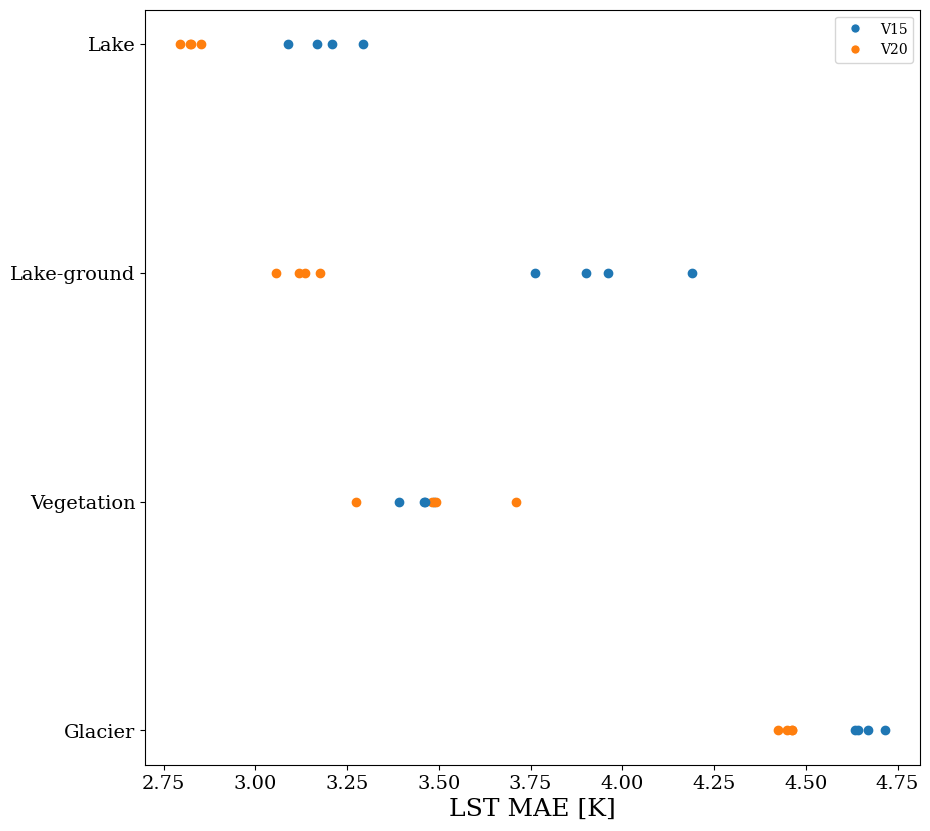

In [212]:
conditions = [lake_condition,lake_ground_condition,vegetation_condition,glacier_condition]
names = ["Lake", "Lake-ground", "Vegetation", "Glacier"]
shift_plot(df_V15,df_V20,conditions,names,savefig="global_shift_plot")

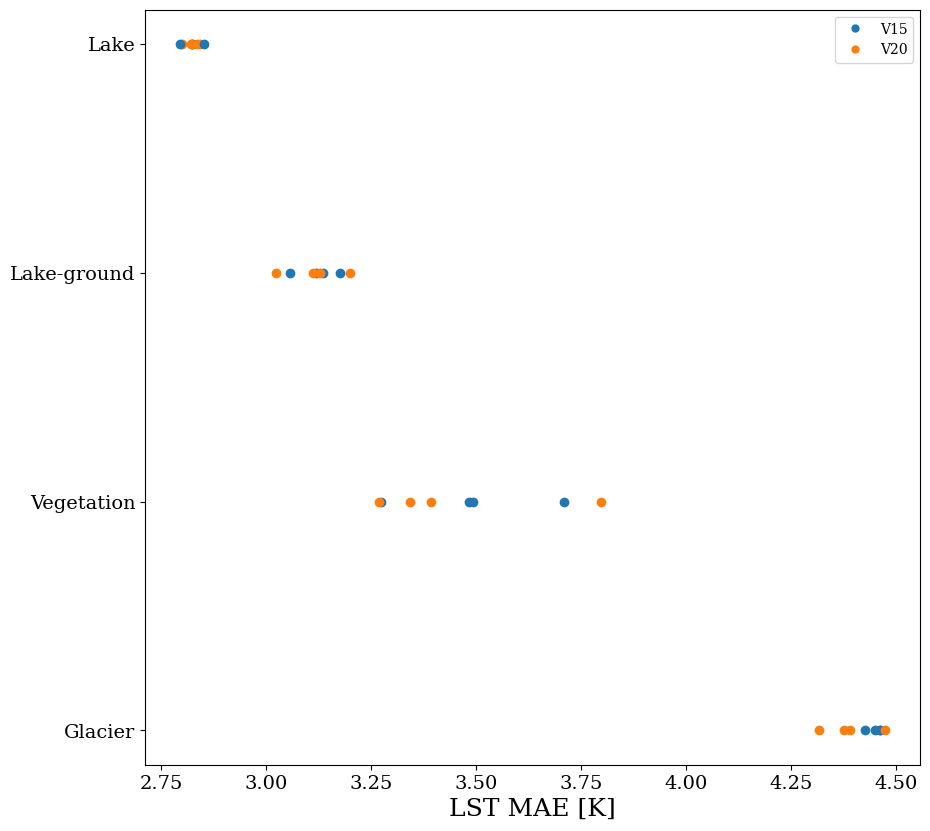

In [527]:
conditions = [lake_condition,lake_ground_condition,vegetation_condition,glacier_condition]
names = ["Lake", "Lake-ground", "Vegetation", "Glacier"]
shift_plot(df_V20,df_V20X,conditions,names,savefig="global_shift_plot_v20X")

In [386]:
df2_c = df_V20.query(vegetation_condition)

df2_averaged = df2_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation


In [387]:
df2_averaged

array([3.27350116, 3.4911325 , 3.48278403, 3.709342  ])

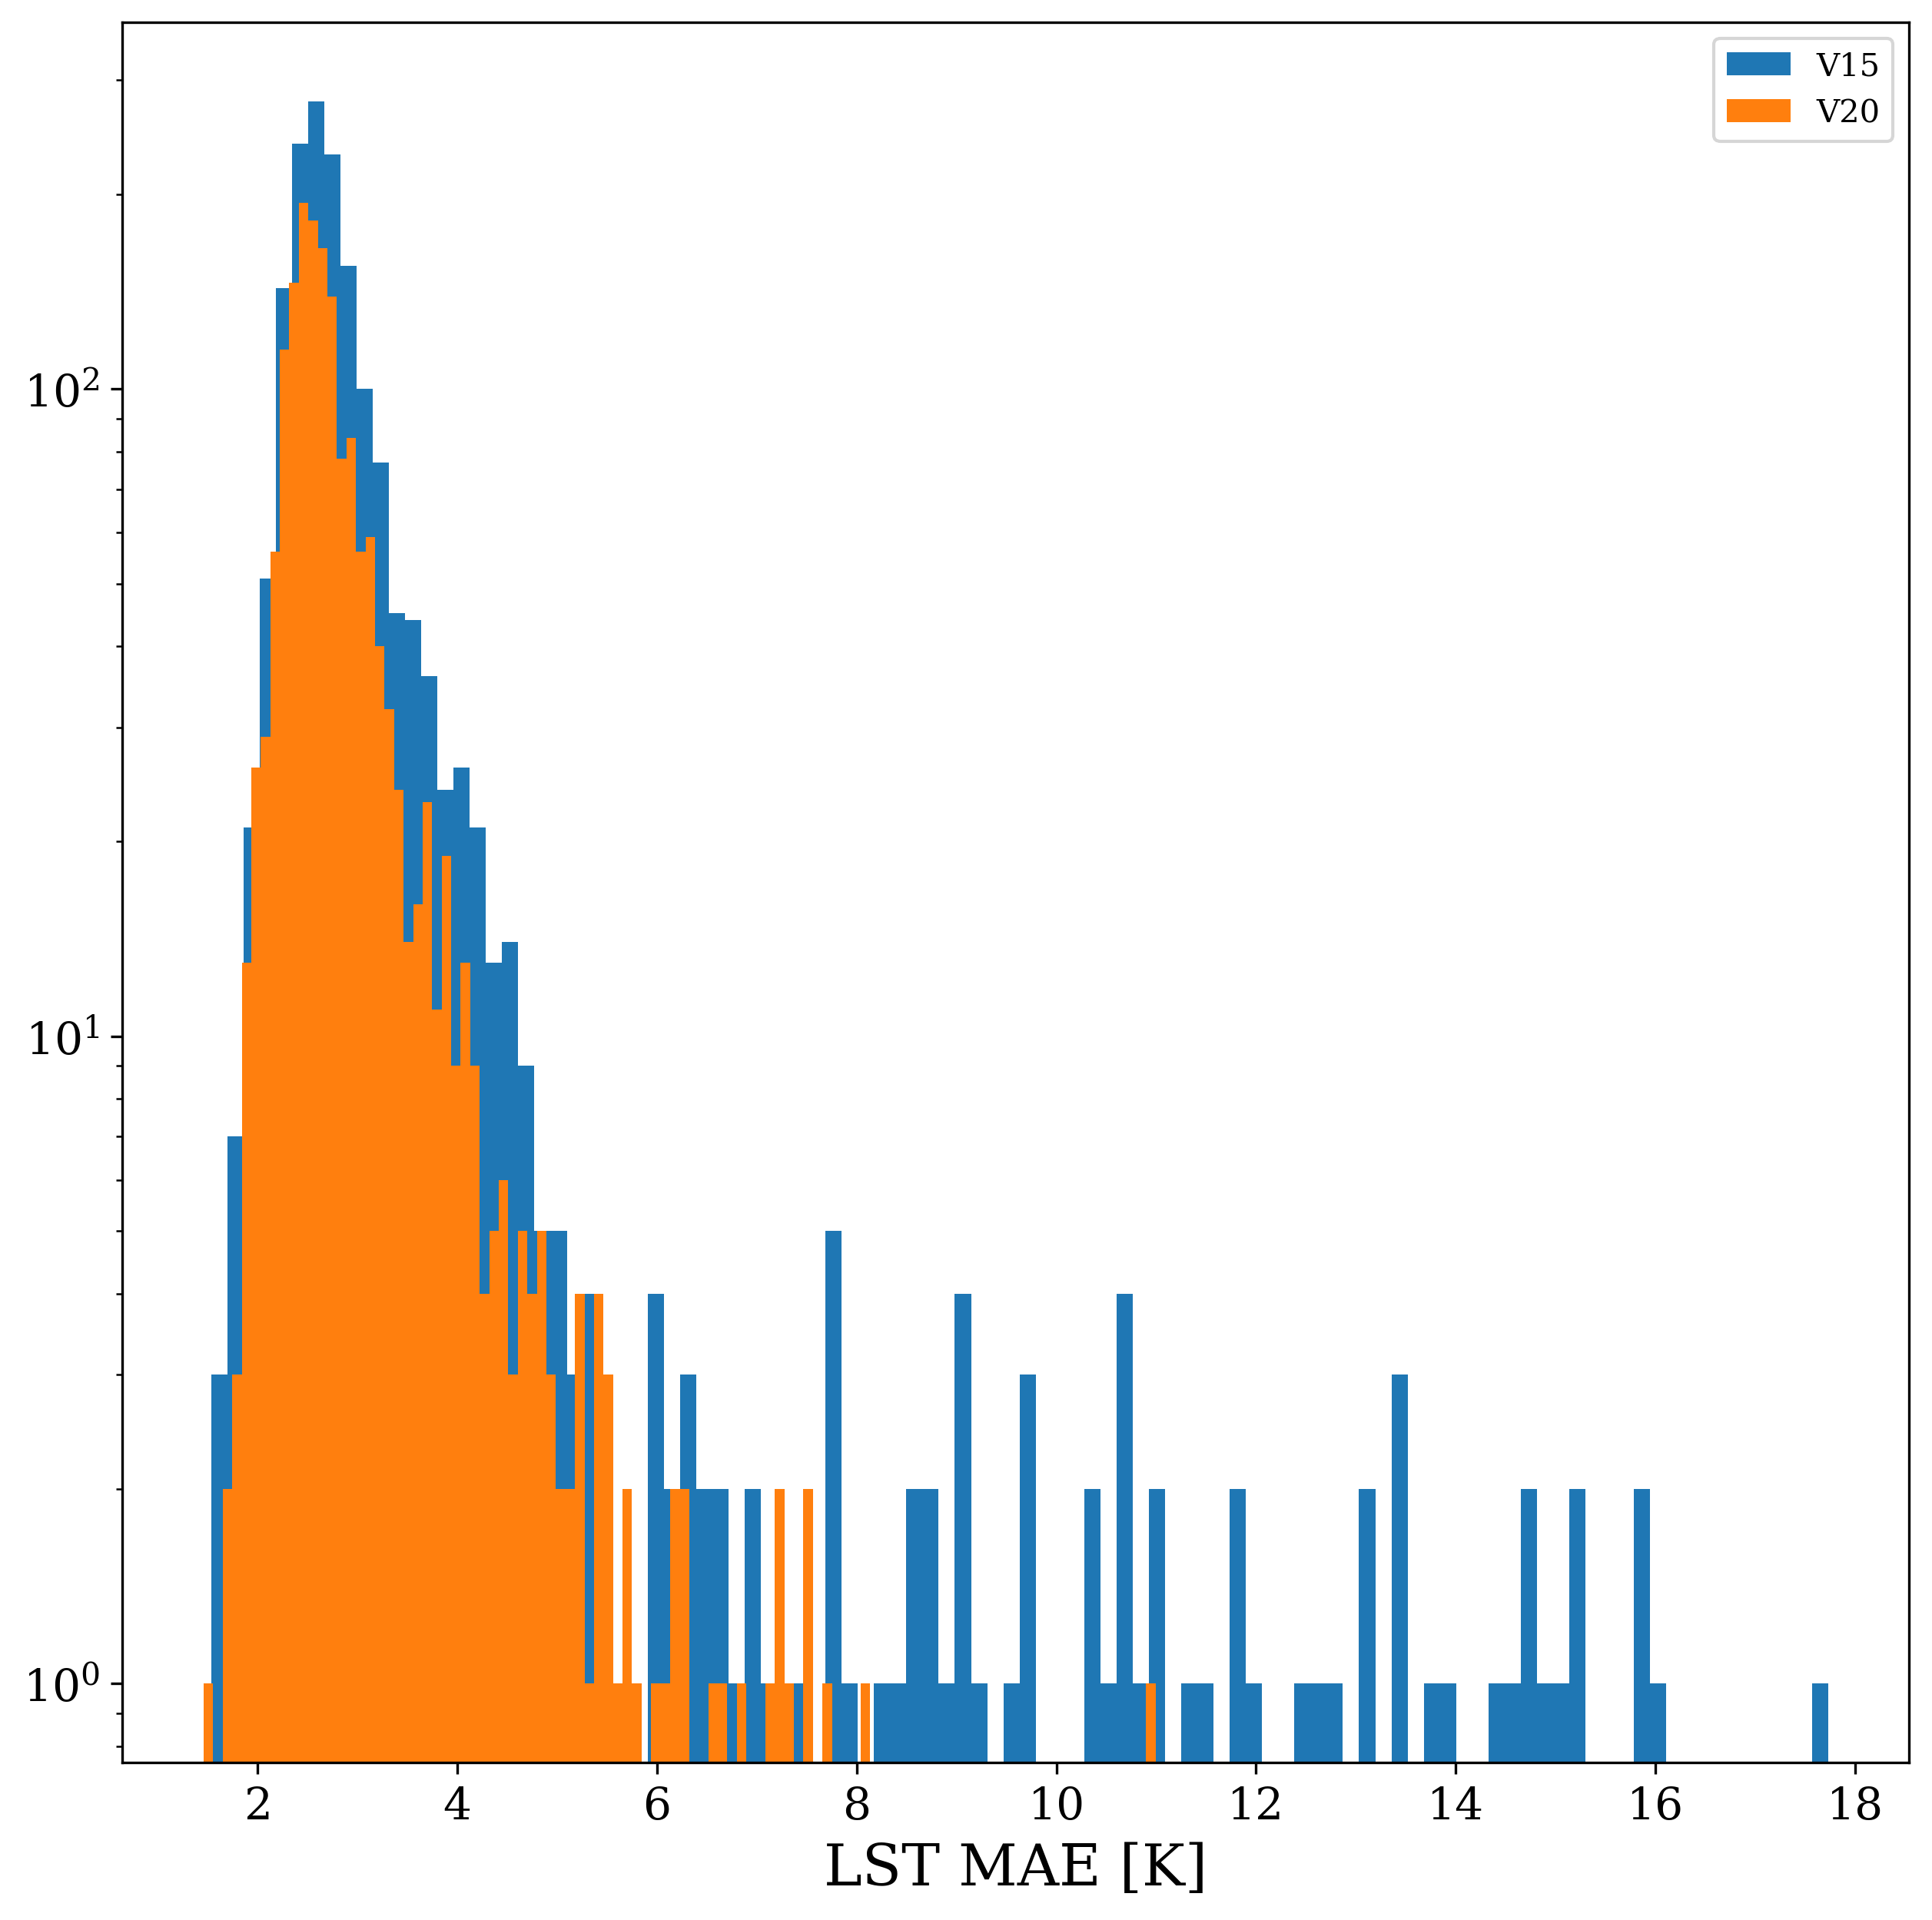

In [408]:
dual_histogram_plot(df_V15.query(lake_condition),df_V20.query(lake_condition),["V15", "V20"],savefig="lakes_histogram_plot")
#dual_histogram_plot(df_V15.query(lake_condition),df_V20.query(lake_condition),["V15", "V20"],savefig=None)

1631
1631


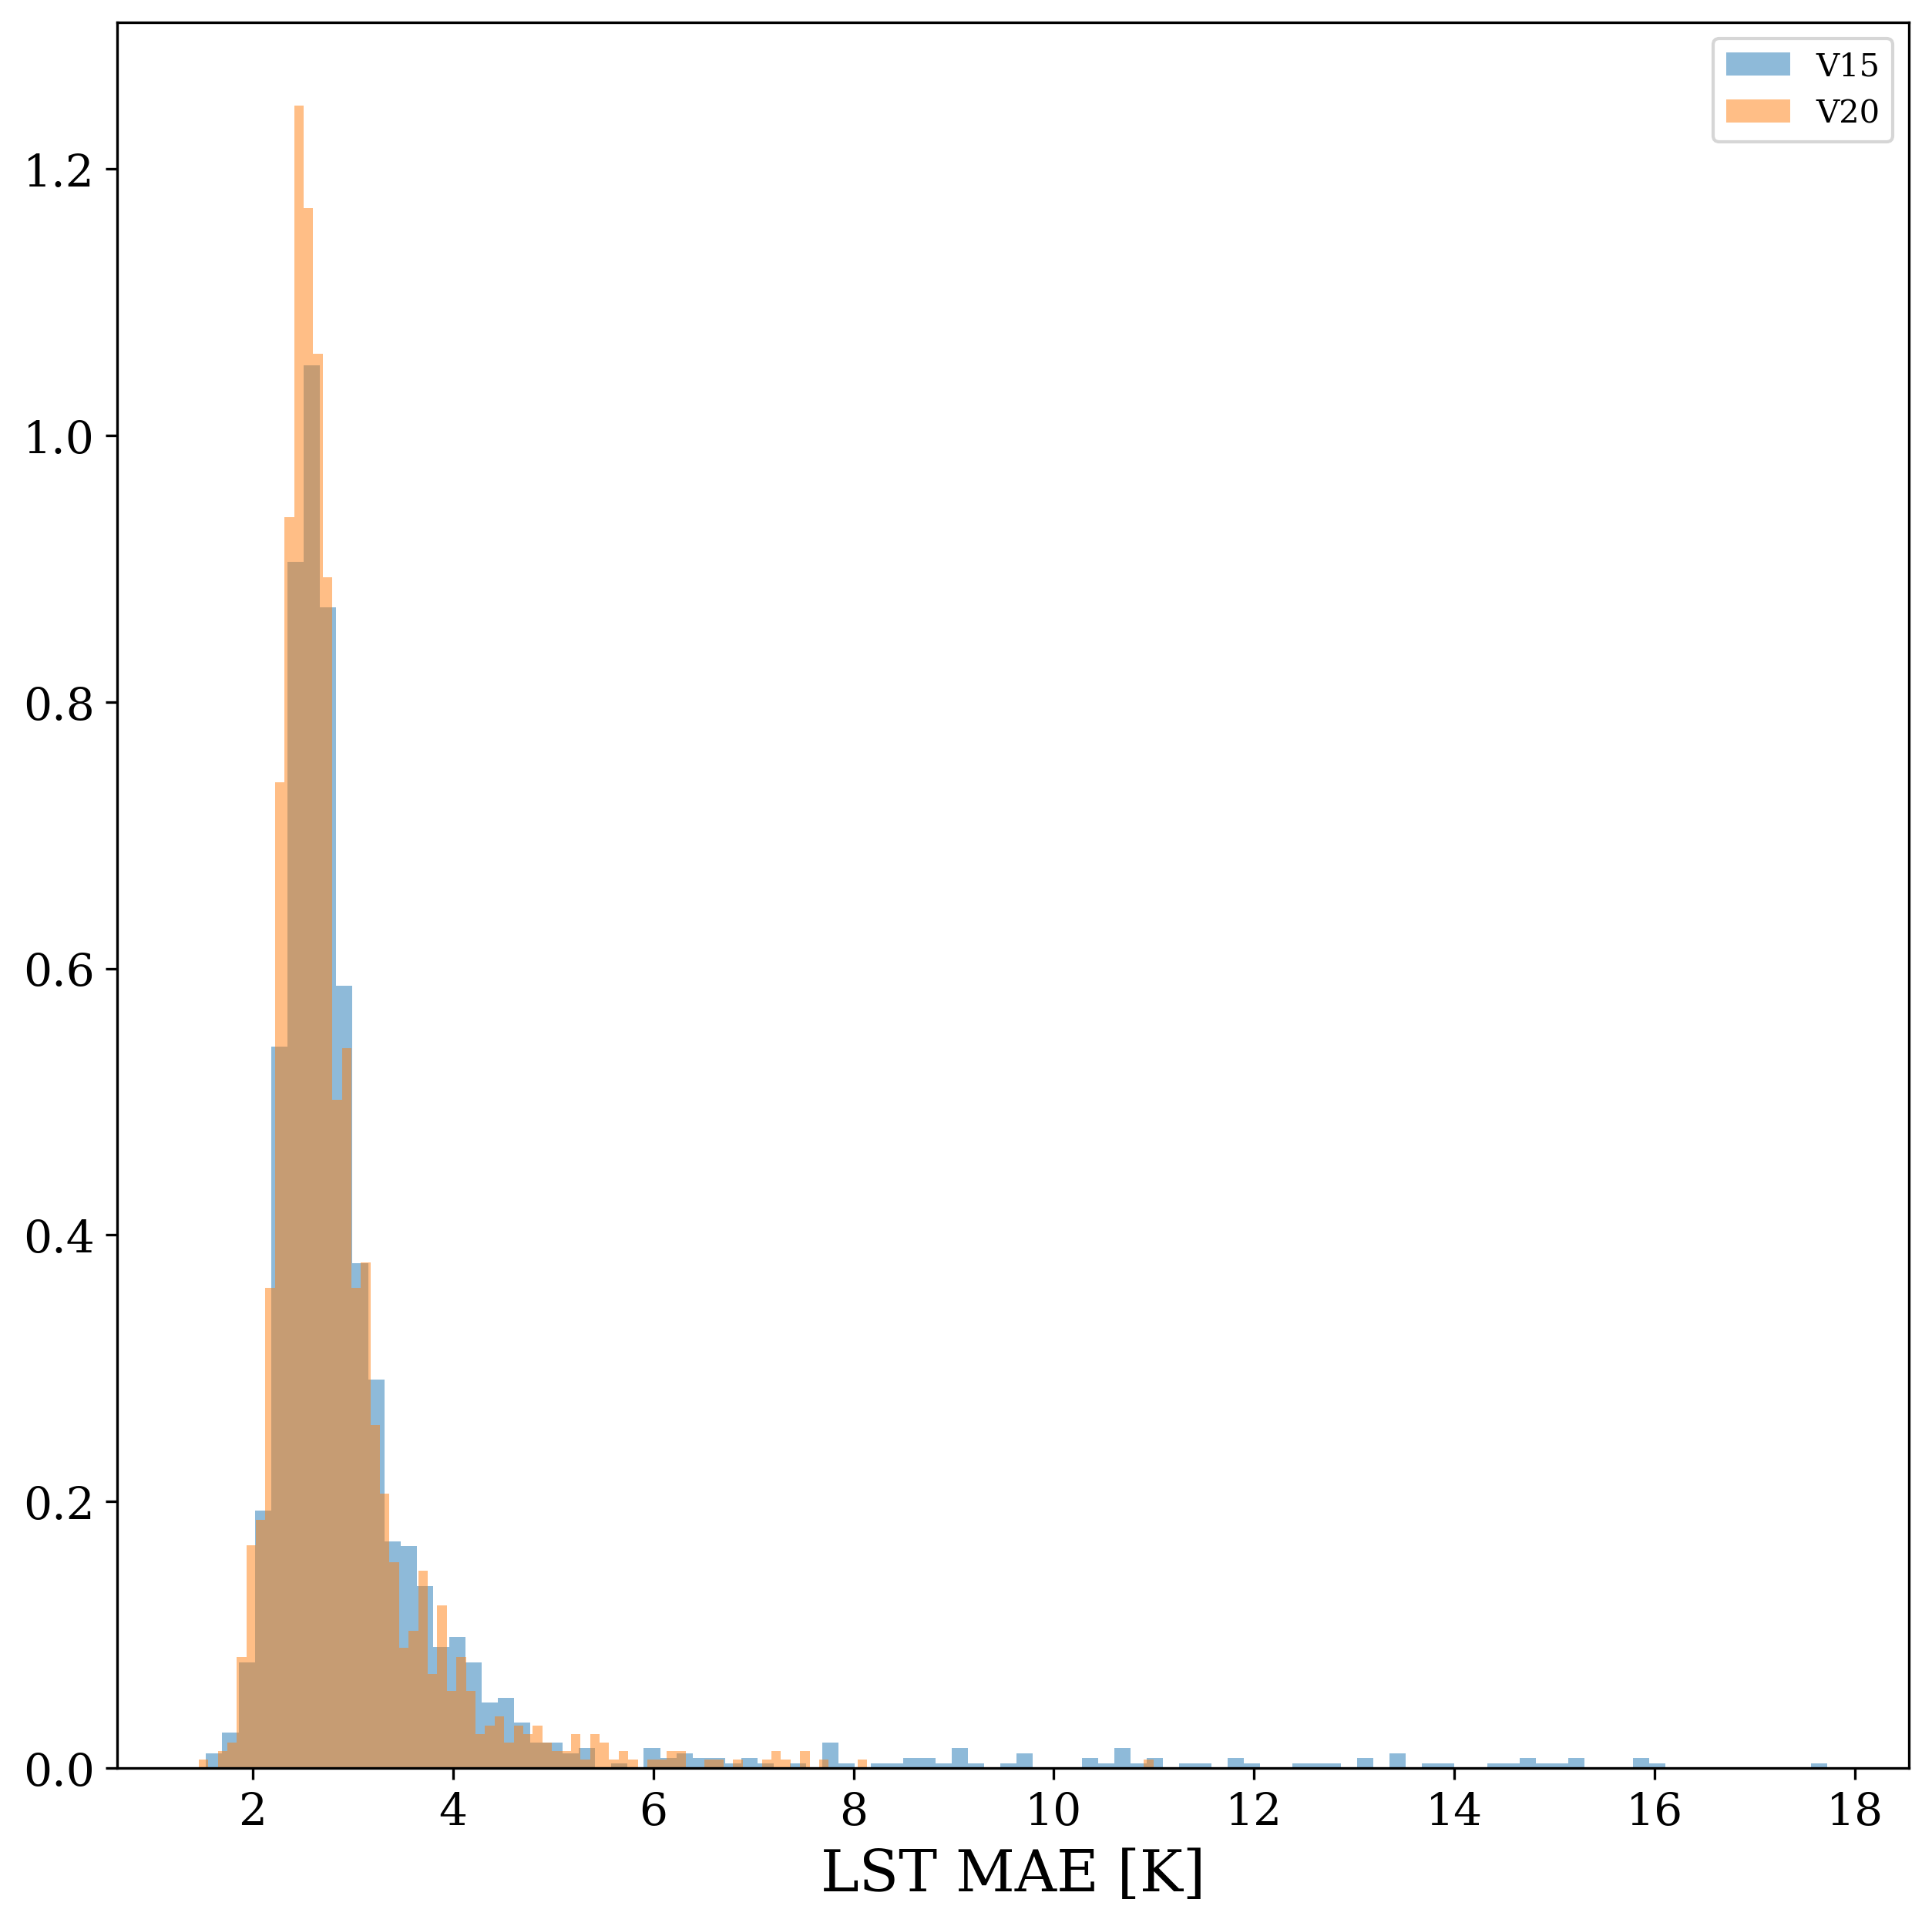

In [549]:
dual_histogram_plot2(df_V15.query(lake_condition),df_V20.query(lake_condition),["V15", "V20"],savefig='example_histogram_linear_yscale')


#### Deep dive on individual bad points

In [213]:
lake_natron_condition                = 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0000'
lake_natron_northern_edge_condition  = 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0000'
lake_blanche_condition               ='latitude_ERA ==  -29.367671674745356 & longitude_ERA == 139.6875'
salt_lake_city_condition             ='latitude_ERA ==  41.17094491970063 & longitude_ERA ==  -113.39999999999998'
farah_province_condition             ='latitude_ERA ==  31.615914311651938 & longitude_ERA == 61.120000000000005'
gujarat_province_condition           ='latitude_ERA ==  24.028095261448925 & longitude_ERA ==  69.0'
toshka_lakes_condition               ='latitude_ERA ==  23.18500423251539 & longitude_ERA ==  30.900000000000006'
all_northern_canada_points_condition = '50.0 < latitude_ERA & -130 < longitude_ERA < -80'


caspain_1_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==   49.125'
caspain_2_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==    49.5'
caspain_3_condition = 'latitude_ERA ==  46.51052023808231 & longitude_ERA ==    49.5'
caspain_4_condition = 'latitude_ERA ==  47.072580762649004 & longitude_ERA ==    51.599999999999994'
caspian_condition = f"{caspain_1_condition} | {caspain_2_condition} | {caspain_3_condition} | {caspain_3_condition}"


bering_glacier_condition = 'latitude_ERA == 60.280999861571715   & longitude_ERA ==    -143.4666666666667'
juncal_glacier_condition = 'latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998'

In [214]:
all_conditions = [lake_natron_condition,
                 lake_natron_northern_edge_condition,
                  lake_blanche_condition,
                  salt_lake_city_condition,
                  farah_province_condition,
                  gujarat_province_condition,
                  toshka_lakes_condition,
                  all_northern_canada_points_condition,
                  caspian_condition,
                  bering_glacier_condition,
                  juncal_glacier_condition
                 ]

names = ['Lake Natron centre', 
           'Lake Natrom, north', 
           'Lake Blanche',
           'Great Salt Lake Desert', 
           'Farah Province', 
           'Gujarat Province', 
           'Toshka Lakes', 
           'Northern Canada',
           'Caspian',
           'Bering Glacier', 
           'Juncal Glacier',
          ]



In [217]:
i = 0
for c in all_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    
    
    
    
    
    
    
    print("----------------------------")

Lake Natron centre
Summary statistics: 1 || 0.119602 1.478581 0.813442 0.532326 || 1.353858 2.449394 2.607876
----------------------------
Lake Natrom, north
Summary statistics: 1 || 0.128982 0.37359 0.511549 0.175062 || 0.717707 1.572047 1.235167
----------------------------
Lake Blanche
Summary statistics: 1 || 0.829303 0.700163 1.538067 0.277111 || -0.422041 0.031714 -0.7499
----------------------------
Great Salt Lake Desert
Summary statistics: 1 || 0.259263 0.412639 0.919923 0.617111 || -0.182307 2.915094 0.247813
----------------------------
Farah Province
Summary statistics: 1 || 0.013833 0.19343 0.086472 0.217429 || 0.219371 0.18825 -0.131579
----------------------------
Gujarat Province
Summary statistics: 1 || 2.544253 1.121596 0.416202 1.039276 || -1.255321 4.209924 5.242606
----------------------------
Toshka Lakes
Summary statistics: 1 || 0.911747 0.401079 0.262995 0.13974 || -0.385672 -1.149529 -1.282054
----------------------------
Northern Canada
Summary statistics: 585

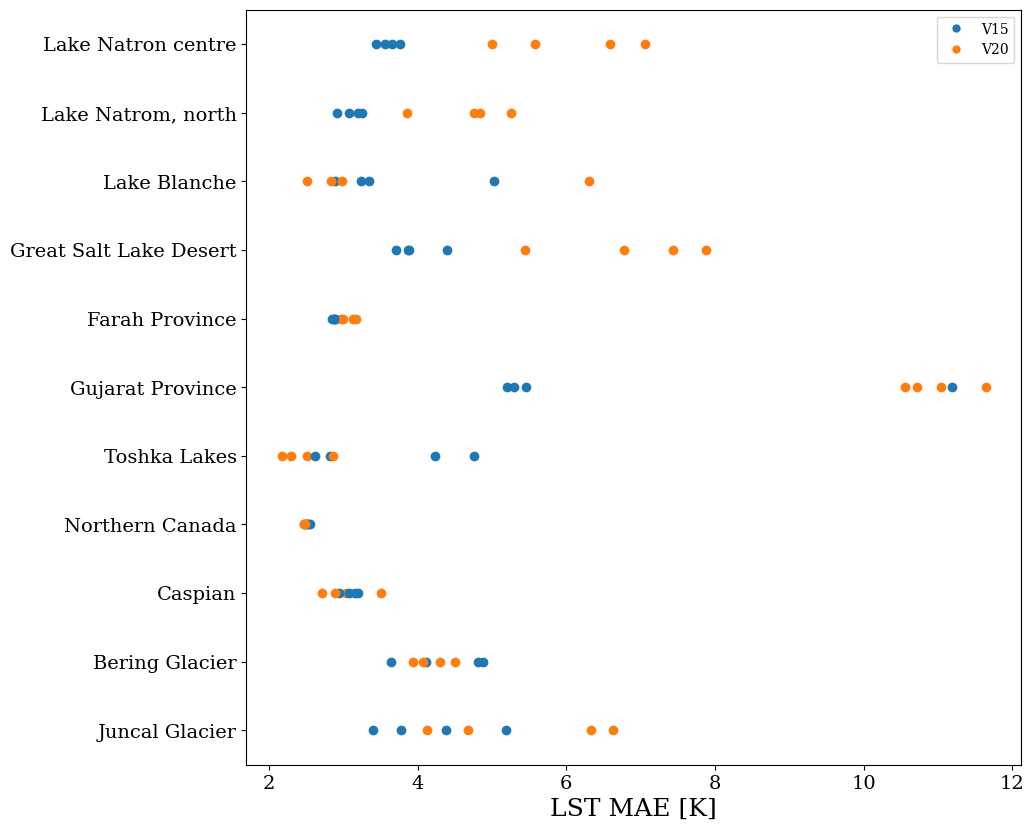

In [150]:
shift_plot(df_V15,df_V20,all_conditions,names,savefig="selected_points_shift_plot")

#### Global numbers for lakes 

In [231]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import matplotlib.colors as mc
import matplotlib.colorbar as cb 


def RobinsonPlot(df,z,vmin,vmax,cmap,markersize,savefig,ncircles):


    #Setup plotting env
    fig = plt.figure(figsize=[30,20])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    cax = fig.add_axes([0.32, 0.11, 0.4, 0.0125])

    #Get data
    x = df['latitude_ERA']
    y = df['longitude_ERA']
    z1 = df[z]
    
    
    #Normalise
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    #Colorbar
    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                               norm=norm,
                               orientation='horizontal'
                               )
    #Scatter points
    sc = ax.scatter(y,x,transform=ccrs.PlateCarree(),
                    s=markersize,
                    c=cmap(norm(z1)),
                    linewidths=1, 
                    alpha=.7)


    #Latitude cutoffs
    ax.plot([-180,180],[70,70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')
    ax.plot([-180,180],[-70,-70],transform=ccrs.PlateCarree(),c='0.5', linestyle='--')


    
    #Formatting
    cax.tick_params(labelsize=30)
    cax.set_xlabel(r'$\delta_{\rm V20}$ (K)',fontsize=34)
    

    ax.coastlines()
    ax.set_aspect('auto') #Force projection aspect ratio
    
    ax.scatter(180,0,c='1',transform=ccrs.PlateCarree(),s=100,alpha=0.1) #invisible point to set plot limits. Hacky, but works OK.
    ax.scatter(-180,0,c='1',transform=ccrs.PlateCarree(),s=100,alpha=0.1) #invisible point to set plot limits. Hacky, but works OK.

    #ax.scatter(180,0,c='k')

    #ax.set_xlim(-180,180)
    
    
    
    
    
    #Extra circles
    row = df.sort_values(by=['delta'],ascending=False).iloc[0:ncircles]
    xsel = row['latitude_ERA']
    ysel = row['longitude_ERA']
    
    sc_extra = ax.scatter(ysel,xsel,transform=ccrs.PlateCarree(),
                          s=200, facecolors='none', edgecolors='C2',lw=2
                          )

    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)    
    
    
    
    
    
    
    
    
    


In [507]:
df_V15['delta'] = df_V20['mean_error'] - df_V15['mean_error']
df_V15['deltaV20X'] = df_V20X['mean_error'] - df_V15['mean_error']
df_V15['deltaV15X'] = df_V15X['mean_error'] - df_V15['mean_error']

df_V15["improvement_in_delta"] = df_V15['delta']- df_V15['deltaV20X']


df_lake_v15    = df_V15.query(lake_condition)



## Aside - quick exploration of new metric 

In [502]:
n=10
df10 = df_lake_v15.sort_values(by=['improvement_in_delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta','deltaV20X','deltaV15X']])

,latitude_ERA,longitude_ERA,delta,deltaV20X,deltaV15X
101073,41.170945,-113.40000,2.915094,0.247813,-0.182307
100571,40.889915,-113.40000,1.270998,-0.933867,1.080559
84318,31.334884,47.68000,-5.289997,-7.163373,-4.390351
8264,-30.491793,139.84000,-7.287575,-9.114818,-6.918141
8257,-30.491793,137.60000,-9.047363,-10.852462,-6.445845
55693,13.067912,14.34375,1.738063,0.028728,0.292141
89077,34.145187,6.08000,2.197730,0.725637,0.340923
86744,32.740036,43.84000,-0.326436,-1.599022,-1.294764
109391,45.667429,59.25000,-3.460567,-4.661560,-5.382392
107261,44.543308,58.87500,-0.066030,-1.244707,-0.413508


In [503]:
row = df_lake_v15.sort_values(by=['improvement_in_delta'],ascending=False).iloc[1]
display(row)
print("*******************")

print("Coords:", row.latitude_ERA,row.longitude_ERA)


latitude_ERA                        40.889915
longitude_ERA                          -113.4
MODIS_LST                          296.116364
prediction_error_1                   3.514376
prediction_1                       296.007538
prediction_error_2                   4.933787
prediction_2                       292.211334
prediction_error_3                   5.711438
prediction_3                       290.765198
prediction_error_4                   4.102282
prediction_4                       293.812561
V15_clFr                             0.577233
V15_cvhFr                                 0.0
V15_cvlFr                                 0.0
V15_dl                                    3.0
V15_oceanFr                               0.0
V15_si10Fr                           0.002155
V15_z                            12914.527344
V20_clFr                             0.000063
V20_cvhFr                                 0.0
V20_cvlFr                                 0.0
V20_dl                            

*******************
Coords: 40.88991462521181 -113.39999999999998


### --- end aside

In [487]:
n=10
df10 = df_lake_v15.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta']])

,latitude_ERA,longitude_ERA,delta
71526,24.028095,69.000000,4.209925
101073,41.170945,-113.400000,2.915094
38367,-2.388758,36.000000,2.449394
89077,34.145187,6.080000,2.197730
55693,13.067912,14.343750,1.738063
38705,-2.107728,36.000000,1.572047
100571,40.889915,-113.400000,1.270998
57099,14.192033,36.000000,0.934875
96882,38.641672,33.046875,0.850780
94958,37.517551,45.666667,0.815180


In [488]:
#0 - Gujarat
#1 - SLC
#2 -Lake Natron
#3 - Chott Felrhir 
#4 - Lake Chad
#5 - Lake Natron, other
#6 - SLC other
#7 - Sudan/Eritrea border 
#8 - Turkey - Tersakan Lake
#9 - Lake Urmia - Iran

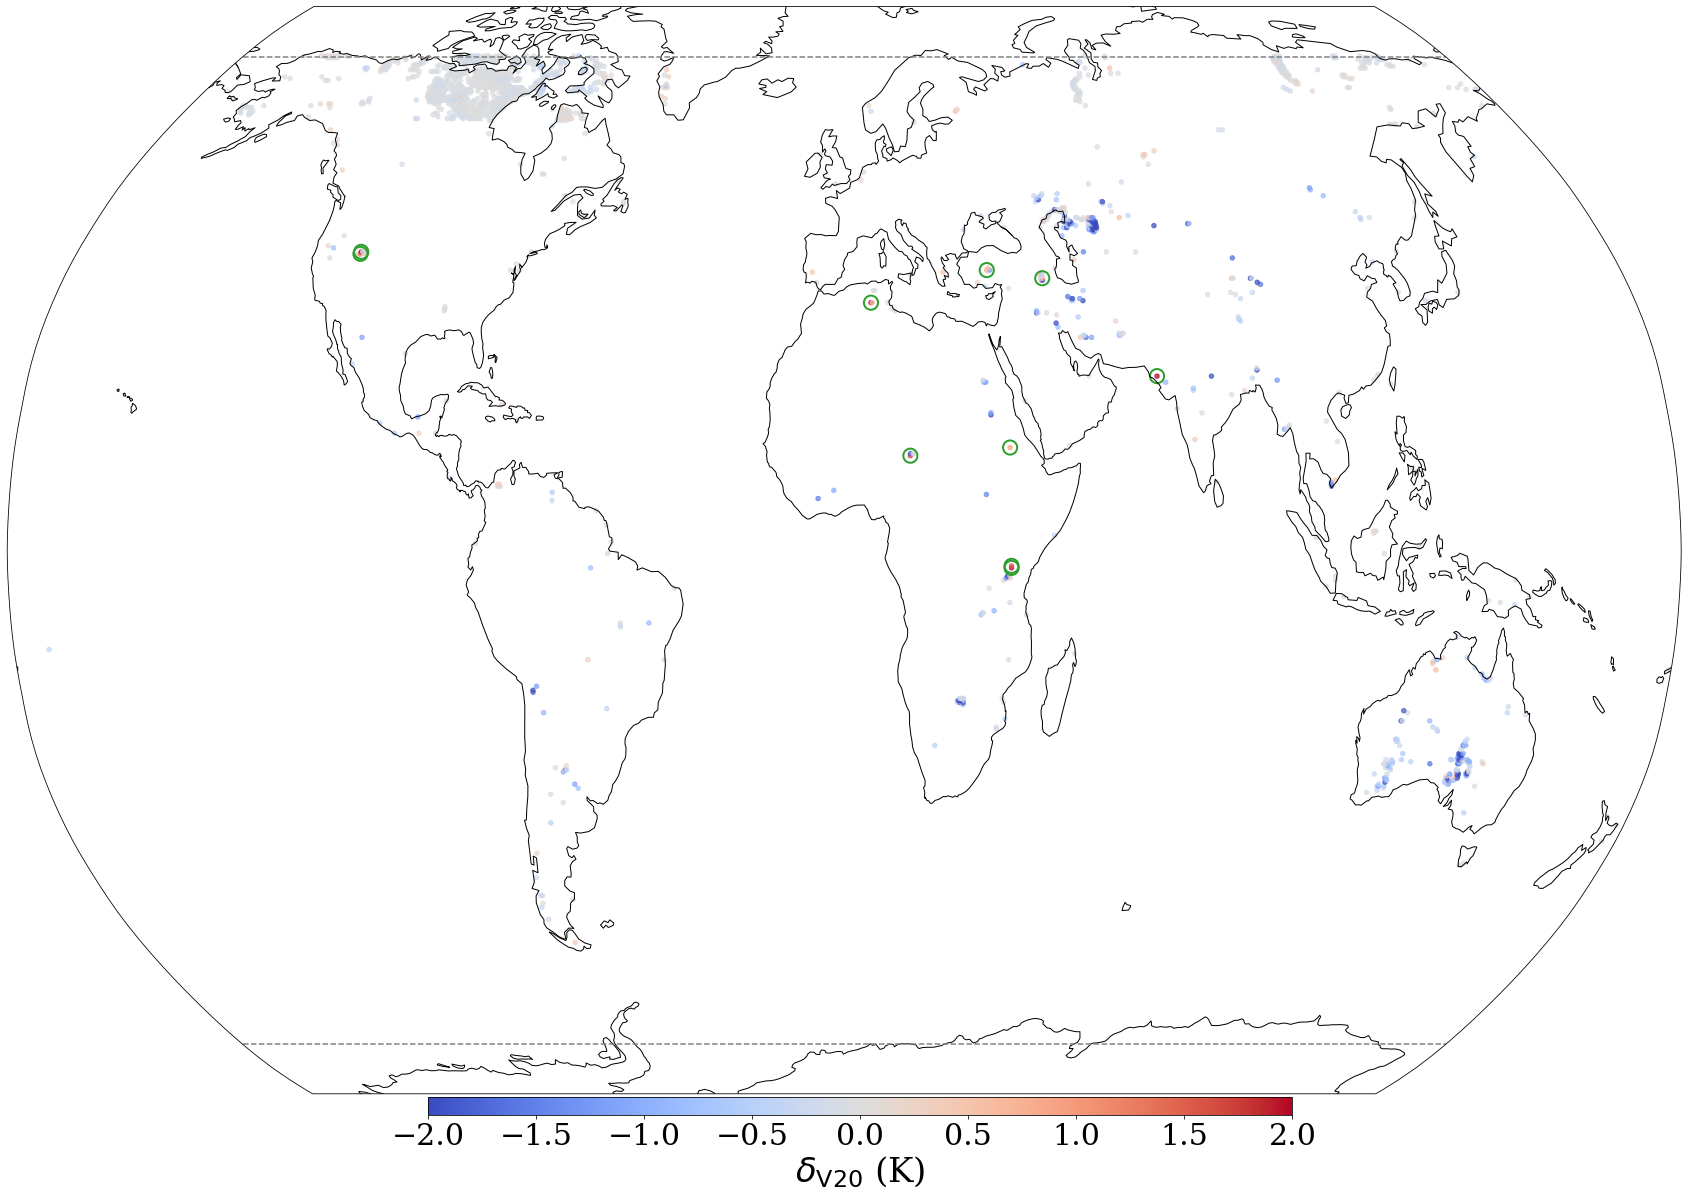

In [489]:
RobinsonPlot(df_lake_v15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='updated_lakes_plot',ncircles=n)


In [529]:
row = df_lake_v15.sort_values(by=['delta'],ascending=False).iloc[3]
display(row)
print("*******************")

print("Coords:", row.latitude_ERA,row.longitude_ERA)



print("*******************")
display(df_V20.query(f'latitude_ERA =={row.latitude_ERA} & longitude_ERA == {row.longitude_ERA}').iloc[0])

latitude_ERA                      34.145187
longitude_ERA                          6.08
MODIS_LST                        309.881287
prediction_error_1                 3.779064
prediction_1                     312.784729
prediction_error_2                 2.887079
prediction_2                     311.751648
prediction_error_3                 3.593253
prediction_3                     313.033844
prediction_error_4                 2.865891
prediction_4                     310.210388
V15_clFr                           0.332777
V15_cvhFr                          0.001161
V15_cvlFr                          0.014613
V15_dl                             20.77832
V15_oceanFr                             0.0
V15_si10Fr                              0.0
V15_z                           -171.761841
V20_clFr                           0.000018
V20_cvhFr                          0.001739
V20_cvlFr                          0.021911
V20_dl                                  1.0
V20_oceanFr                     

*******************
Coords: 34.145187223212716 6.0800000000000125
*******************


latitude_ERA                      34.145187
longitude_ERA                          6.08
MODIS_LST                        309.881287
prediction_error_1                 4.865869
prediction_1                     314.605072
prediction_error_2                 6.099921
prediction_2                     315.916138
prediction_error_3                 5.160341
prediction_3                      314.87326
prediction_error_4                 5.790074
prediction_4                     315.598877
V15_clFr                           0.332777
V15_cvhFr                          0.001161
V15_cvlFr                          0.014613
V15_dl                             20.77832
V15_oceanFr                             0.0
V15_si10Fr                              0.0
V15_z                           -171.761841
V20_clFr                           0.000018
V20_cvhFr                          0.001739
V20_cvlFr                          0.021911
V20_dl                                  1.0
V20_oceanFr                     

In [491]:
selected_latitudes = df10.latitude_ERA.to_numpy()
selected_longitudes = df10.longitude_ERA.to_numpy()

In [492]:
new_conditions = []

for i in range(len(selected_latitudes)):
    c = f'latitude_ERA == {selected_latitudes[i]} & longitude_ERA == {selected_longitudes[i]}'
    new_conditions.extend([c])

In [493]:
i = 0



names = ['0 - Gujarat',
'1 - SLC',
'2 -Lake Natron',
'3 - Chott Felrhir', 
'4 - Lake Chad',
'5 - Lake Natron, other',
'6 - SLC other',
'7 - Sudan/Eritrea border',
'8 - Turkey - Tersakan Lake',
'9 - Lake Urmia - Iran',]







for c in new_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    
    
    
    

0 - Gujarat
Summary statistics: 1 || 2.544 1.122 0.416 1.039 || -1.255 4.21 5.243
Change is  Insignificant
1 - SLC
Summary statistics: 1 || 0.259 0.413 0.92 0.617 || -0.182 2.915 0.248
Change is  Insignificant
2 -Lake Natron
Summary statistics: 1 || 0.12 1.479 0.813 0.532 || 1.354 2.449 2.608
Change is  Insignificant
3 - Chott Felrhir
Summary statistics: 1 || 0.41 0.57 0.49 0.578 || 0.341 2.198 0.726
Change is  Insignificant
4 - Lake Chad
Summary statistics: 1 || 0.33 1.212 0.978 0.959 || 0.292 1.738 0.029
Change is  Insignificant
5 - Lake Natron, other
Summary statistics: 1 || 0.129 0.374 0.512 0.175 || 0.718 1.572 1.235
Change is  Insignificant
6 - SLC other
Summary statistics: 1 || 0.832 0.605 0.983 0.072 || 1.081 1.271 -0.934
Change is  Insignificant
7 - Sudan/Eritrea border
Summary statistics: 1 || 0.138 0.084 0.288 0.424 || -0.24 0.935 1.063
Change is  Insignificant
8 - Turkey - Tersakan Lake
Summary statistics: 1 || 0.254 0.201 0.34 0.375 || -0.002 0.851 0.994
Change is  Insigni

In [494]:
new_names = ['Gujarat Province',
             'Great Salt Lake Desert',
             'Lake Natron centre',
             'Chott Felrhir', 
             'Lake Chad',
             'Lake Natron, north',
             'Al Fashaga',
             'Tersakan Lake',
             'Lake Urmia']




pop_conditions = new_conditions.copy() #.del[6]
del pop_conditions[6]

In [495]:
pop_conditions

['latitude_ERA == 24.028095261448925 & longitude_ERA == 69.0',
 'latitude_ERA == 41.17094491970063 & longitude_ERA == -113.39999999999998',
 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0',
 'latitude_ERA == 34.145187223212716 & longitude_ERA == 6.0800000000000125',
 'latitude_ERA == 13.067911638574962 & longitude_ERA == 14.34375',
 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0',
 'latitude_ERA == 14.192033055763279 & longitude_ERA == 36.0',
 'latitude_ERA == 38.64167222536426 & longitude_ERA == 33.046875',
 'latitude_ERA == 37.51755099834911 & longitude_ERA == 45.66666666666666']

In [290]:
len(new_names)

9

In [291]:
len(pop_conditions)

9

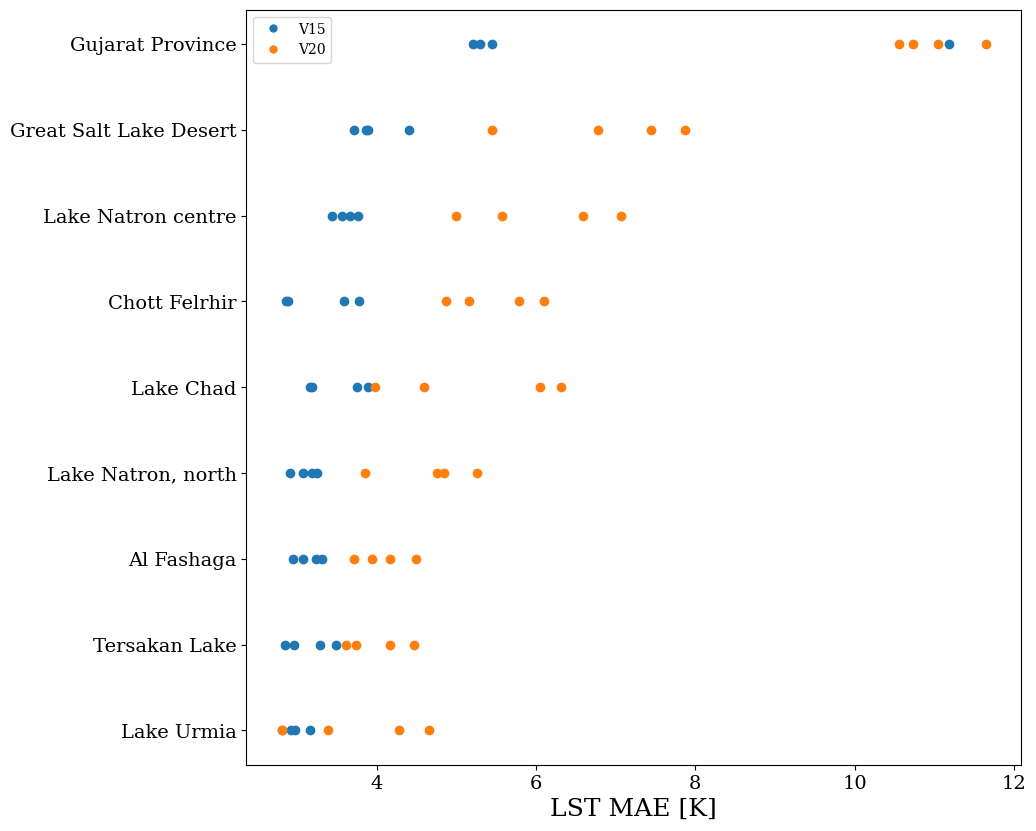

In [292]:
shift_plot(df_V15,df_V20,pop_conditions,new_names,savefig="selected_points_shift_plot_new")

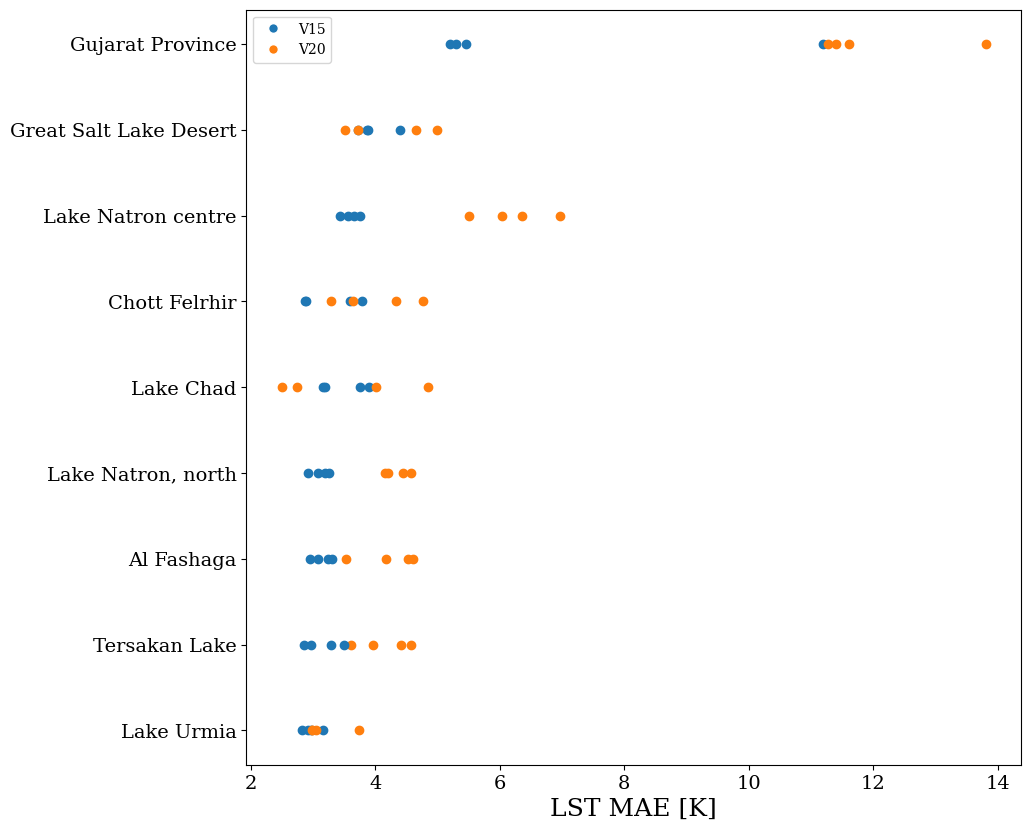

In [504]:
shift_plot(df_V15,df_V20X,pop_conditions,new_names,savefig=None)

#### Vegetation

In [299]:
df10.columns

Index(['latitude_ERA', 'longitude_ERA', 'MODIS_LST', 'prediction_error_1',
       'prediction_1', 'prediction_error_2', 'prediction_2',
       'prediction_error_3', 'prediction_3', 'prediction_error_4',
       'prediction_4', 'V15_clFr', 'V15_cvhFr', 'V15_cvlFr', 'V15_dl',
       'V15_oceanFr', 'V15_si10Fr', 'V15_z', 'V20_clFr', 'V20_cvhFr',
       'V20_cvlFr', 'V20_dl', 'V20_oceanFr', 'V20_si10Fr', 'V20_z',
       'changeAbs_V20V15_clFr', 'changeAbs_V20V15_cvhFr',
       'changeAbs_V20V15_cvlFr', 'changeAbs_V20V15_oceanFr',
       'changeAbs_V20V15_si10Fr', 'changeAbs_V20V15_dl', 'changeAbs_V20V15_z',
       'clFr_change_is_significant', 'cvhFr_change_is_significant',
       'cvlFr_change_is_significant', 'oceanFr_change_is_significant',
       'si10Fr_change_is_significant', 'dl_change_is_significant',
       'z_change_is_significant', 'bitstring', 'median_error', 'mean_error',
       'variance', 'label', 'delta'],
      dtype='object')

In [508]:
df_veg_v15 = df_V15.query(vegetation_condition)
df_veg_v20 = df_V20.query(vegetation_condition)

print(len(df_veg_v15))
n=10
df10 = df_veg_v15.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta','V15_cvhFr','V20_cvhFr']])

58


,latitude_ERA,longitude_ERA,delta,V15_cvhFr,V20_cvhFr
135352,60.843060,-115.555556,1.382829,0.325821,0.000000
3462,-42.576096,171.111111,1.214060,0.278274,0.000000
69914,23.185004,-82.200000,1.029399,0.134162,0.000000
40806,-0.421546,132.187500,1.021315,0.249951,0.000000
134472,60.281000,-102.400000,0.857619,0.180578,0.000000
54269,11.662760,102.937500,0.852969,0.212053,0.000000
2722,-48.477732,-72.400000,0.845627,0.331306,0.202543
105108,43.419187,-4.125000,0.831305,0.340553,0.000000
19009,-19.812640,44.437500,0.775526,0.146665,0.000000
140986,64.215421,23.750000,0.633178,0.306143,0.000000


In [509]:
row = df_veg_v15.sort_values(by=['delta'],ascending=False).iloc[0]
display(row)
print("Coords:", row.latitude_ERA,row.longitude_ERA)

latitude_ERA                        60.84306
longitude_ERA                    -115.555556
MODIS_LST                         272.399689
prediction_error_1                  2.442439
prediction_1                      273.235931
prediction_error_2                  2.776205
prediction_2                      274.047974
prediction_error_3                  2.541098
prediction_3                      273.342621
prediction_error_4                  2.330728
prediction_4                      272.886475
V15_clFr                            0.462168
V15_cvhFr                           0.325821
V15_cvlFr                           0.011147
V15_dl                             10.425781
V15_oceanFr                              0.0
V15_si10Fr                               0.0
V15_z                             1469.22644
V20_clFr                            0.511656
V20_cvhFr                                0.0
V20_cvlFr                                0.0
V20_dl                             16.338867
V20_oceanF

Coords: 60.84306004246005 -115.55555555555554


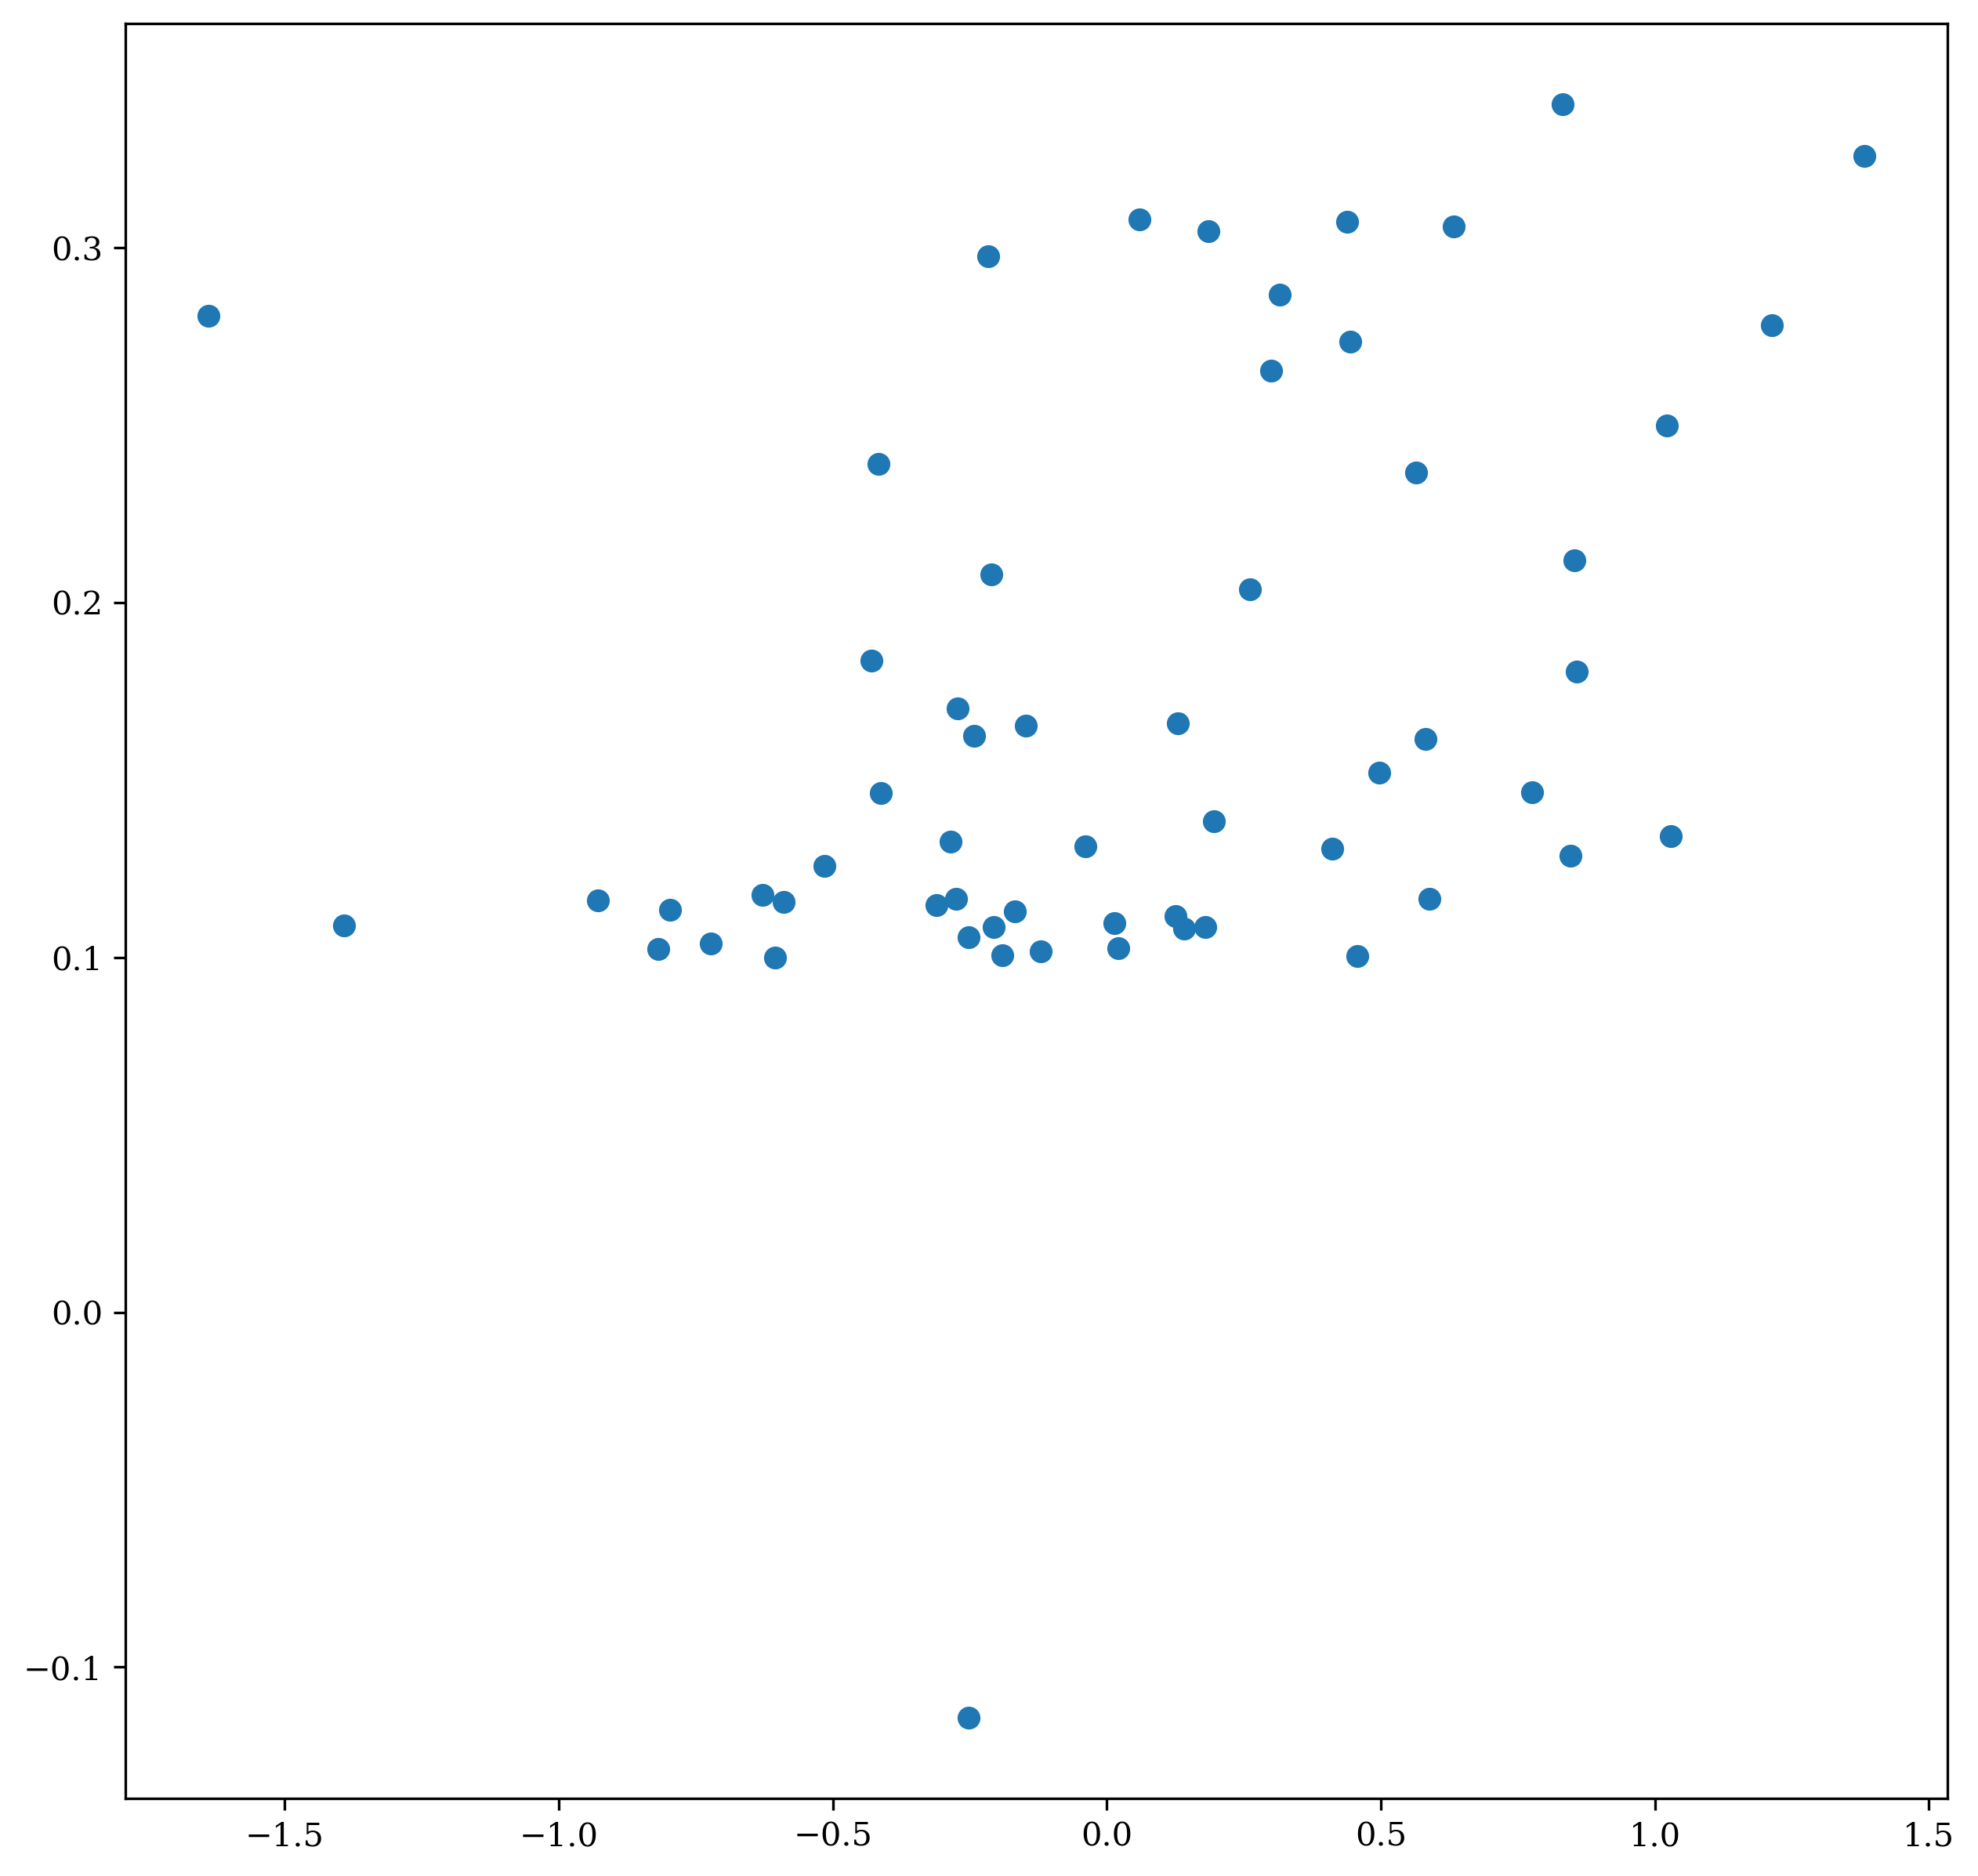

In [510]:


df_plot = df_veg_v15.copy()
df_plot["veg_shift"] = df_plot['V15_cvhFr'] - df_plot['V20_cvhFr'] 
plt.rcParams["font.family"] = "serif"
    
    
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

ax.scatter(df_plot['delta'],df_plot["veg_shift"])

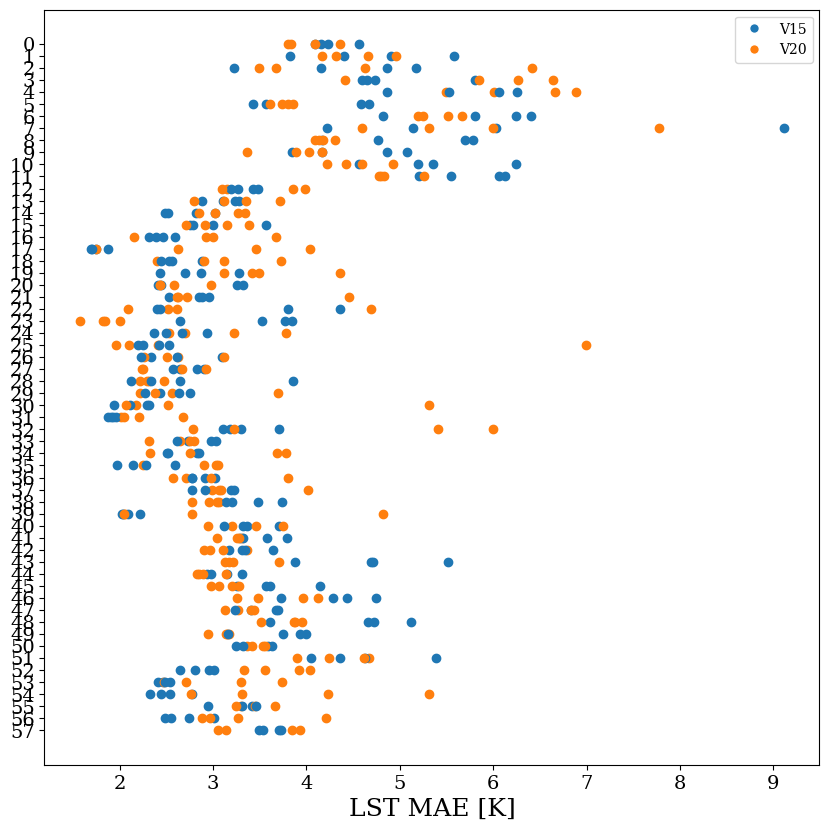

In [511]:


veg_conditions = []
veg_names = []


lats = df_veg_v15['latitude_ERA'].to_numpy()
lons = df_veg_v15['longitude_ERA'].to_numpy()

for i in range(len(df_veg_v15)):
    c = f'latitude_ERA == {lats[i]} & longitude_ERA == {lons[i]}'
    veg_conditions.extend([c])
    veg_names.extend([i])



shift_plot(df_veg_v15,df_veg_v20,veg_conditions,veg_names,savefig=None)

small nosie point: 8
small nosie point: 11
small nosie point: 17
small nosie point: 19
small nosie point: 23
small nosie point: 31
small nosie point: 35
small nosie point: 38
small nosie point: 43
small nosie point: 45
small nosie point: 49
small nosie point: 52
small nosie point: 53
small nosie point: 54
yarp


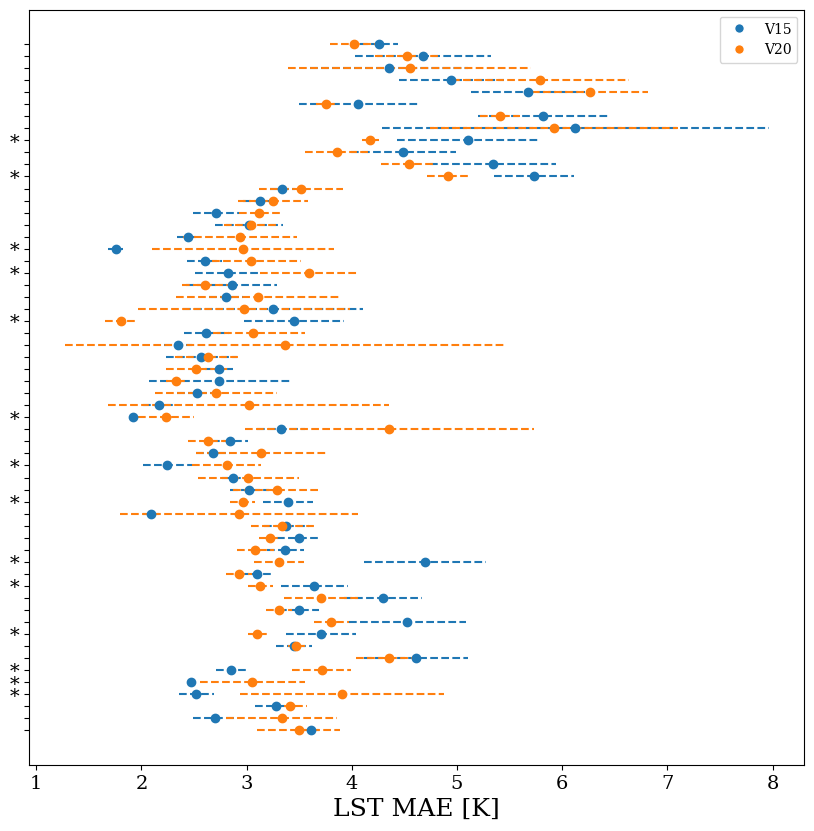

In [512]:
idxs = shift_plot_averaged(df_veg_v15,df_veg_v20,veg_conditions,veg_names,savefig='veg_plot_noise')

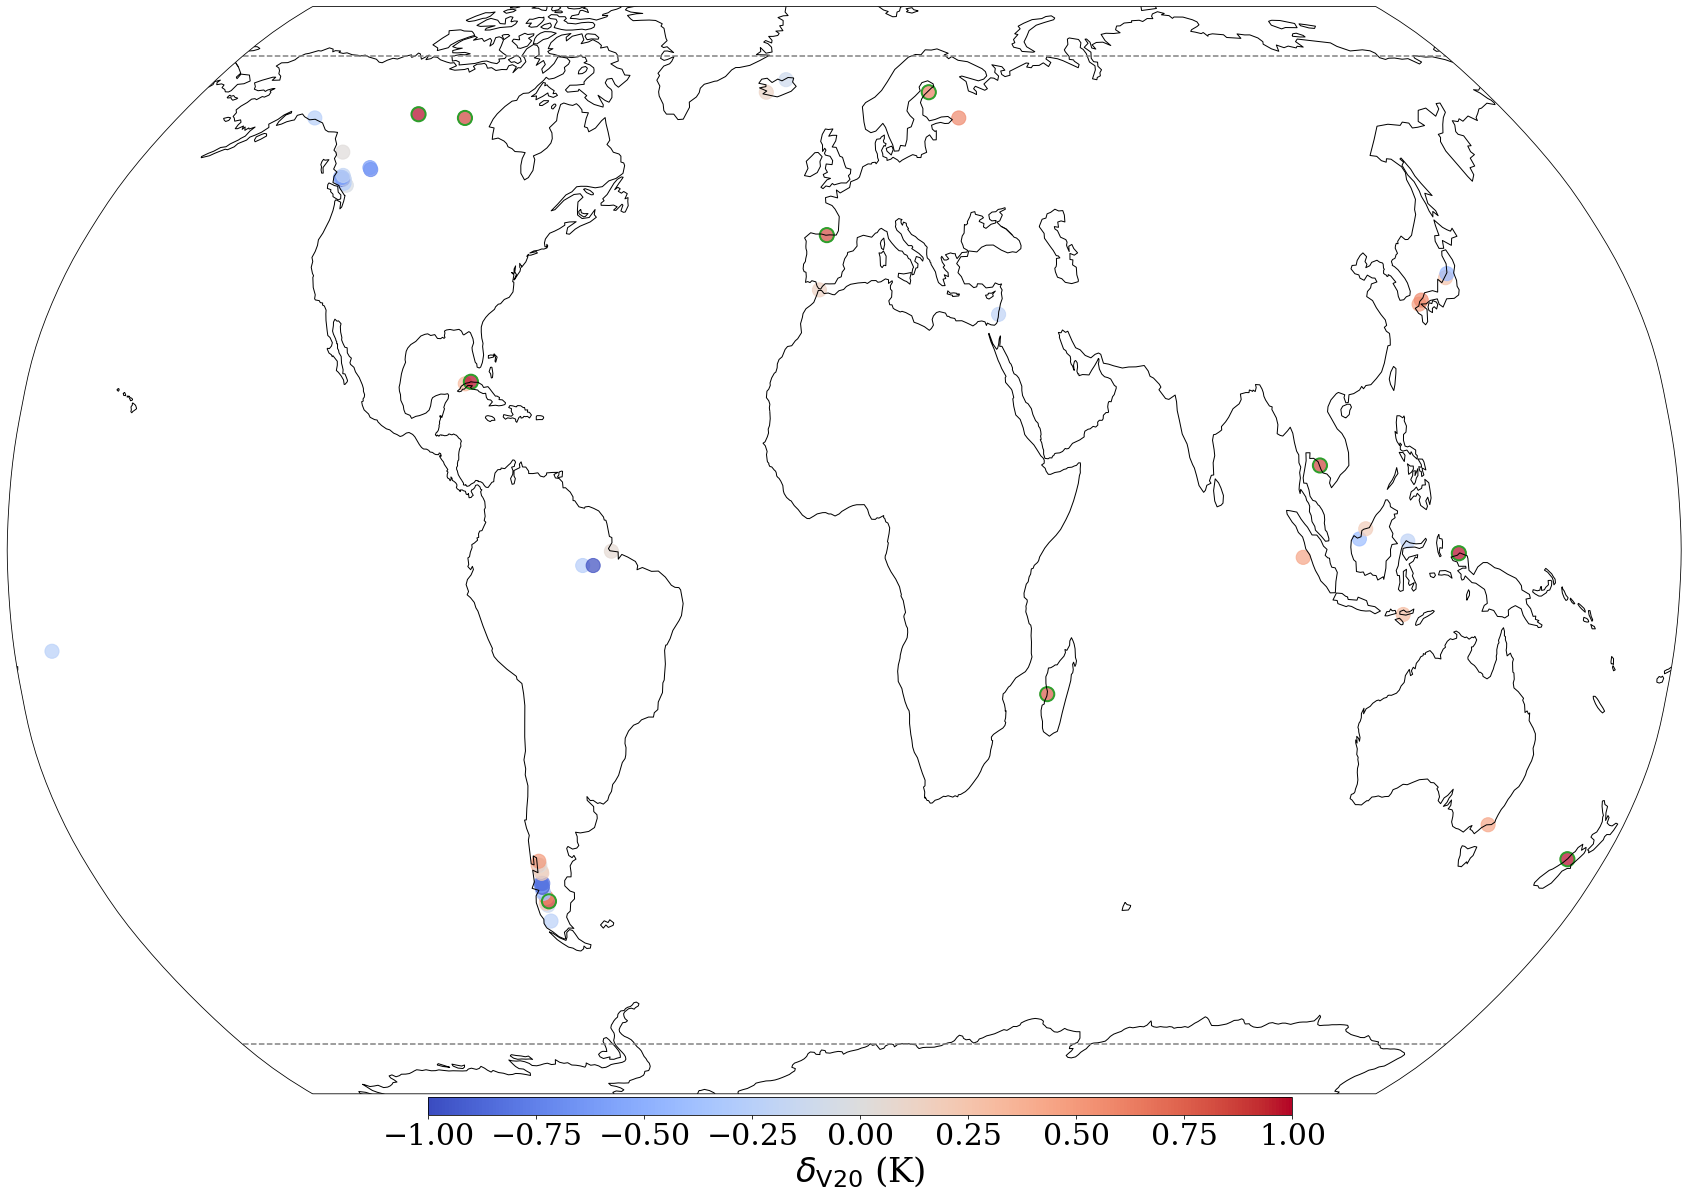

In [513]:
n=10
RobinsonPlot(df_veg_v15,'delta',vmin=-1,vmax=+1,cmap=plt.cm.coolwarm,markersize = 200,savefig=None,ncircles=n)


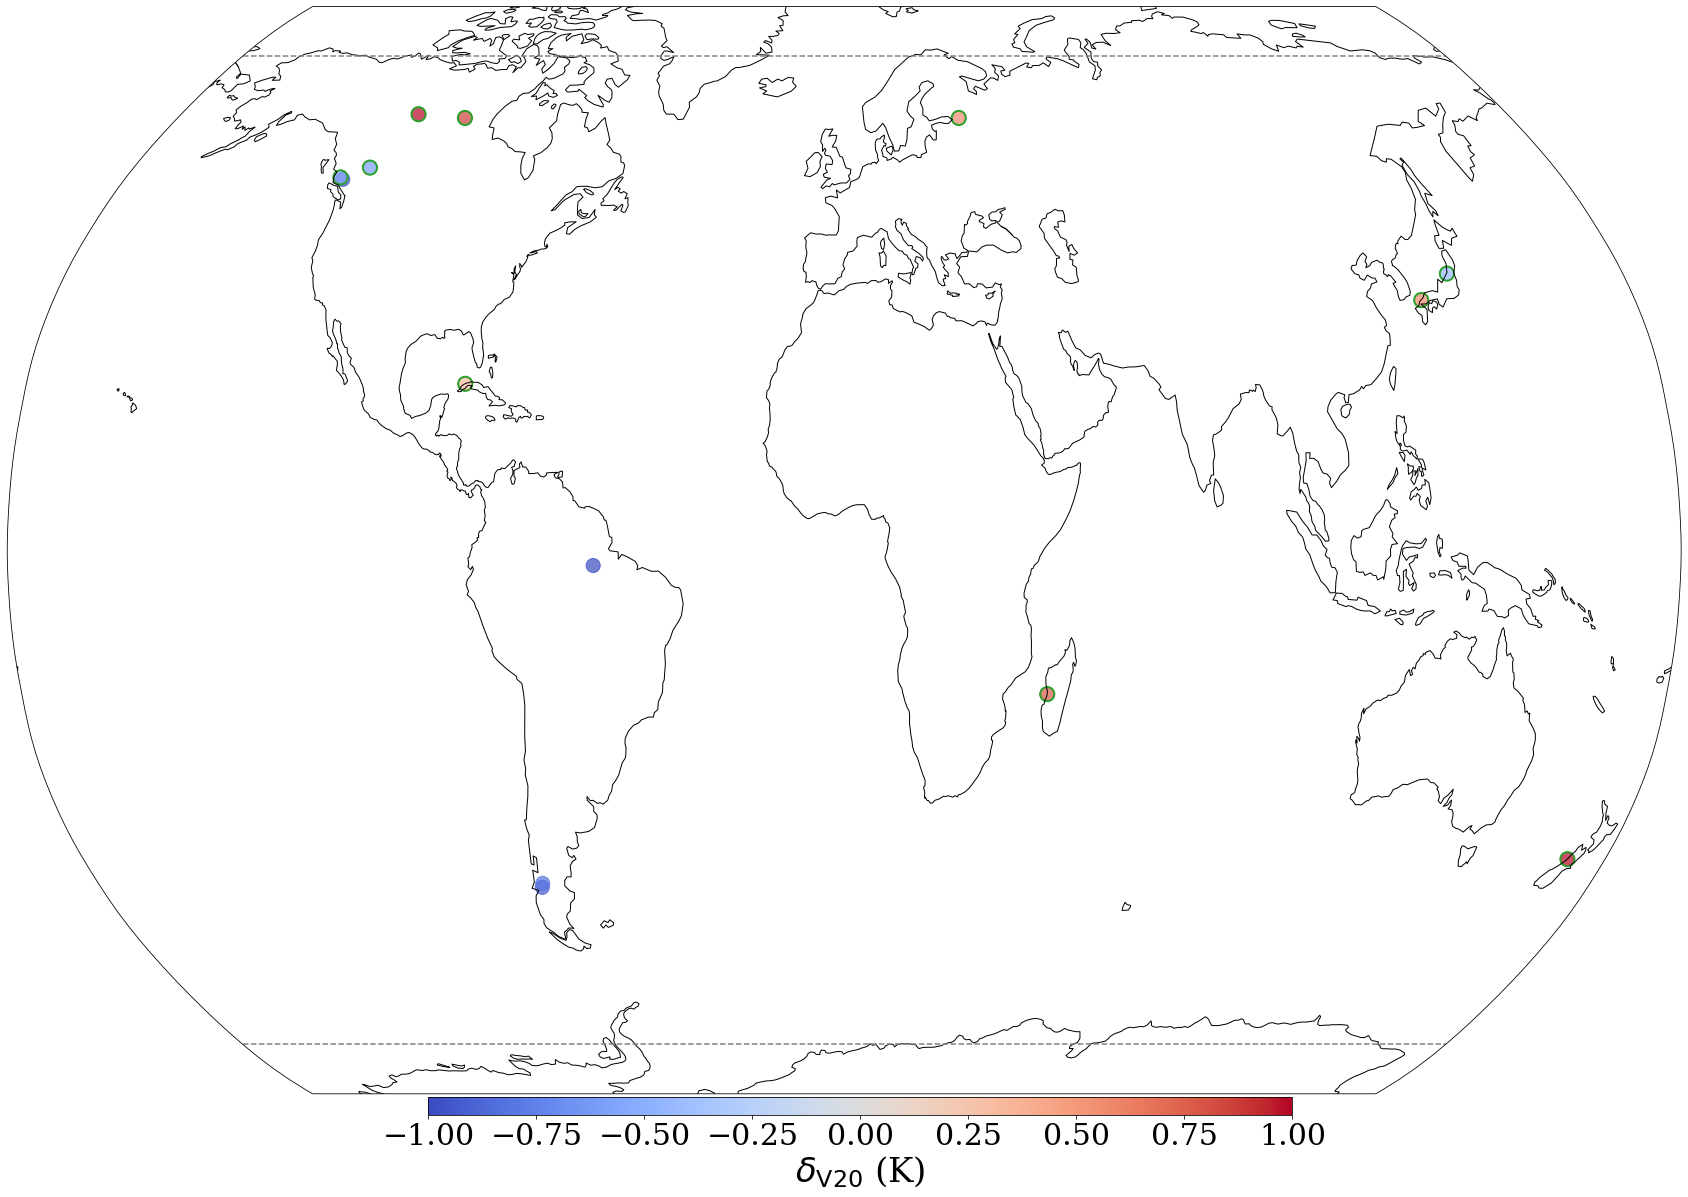

In [514]:
RobinsonPlot(df_veg_v15.iloc[idxs],'delta',vmin=-1,vmax=+1,cmap=plt.cm.coolwarm,markersize = 200,savefig=None,ncircles=n)


In [520]:
df_veg_v15.columns

Index(['latitude_ERA', 'longitude_ERA', 'MODIS_LST', 'prediction_error_1',
       'prediction_1', 'prediction_error_2', 'prediction_2',
       'prediction_error_3', 'prediction_3', 'prediction_error_4',
       'prediction_4', 'V15_clFr', 'V15_cvhFr', 'V15_cvlFr', 'V15_dl',
       'V15_oceanFr', 'V15_si10Fr', 'V15_z', 'V20_clFr', 'V20_cvhFr',
       'V20_cvlFr', 'V20_dl', 'V20_oceanFr', 'V20_si10Fr', 'V20_z',
       'changeAbs_V20V15_clFr', 'changeAbs_V20V15_cvhFr',
       'changeAbs_V20V15_cvlFr', 'changeAbs_V20V15_oceanFr',
       'changeAbs_V20V15_si10Fr', 'changeAbs_V20V15_dl', 'changeAbs_V20V15_z',
       'clFr_change_is_significant', 'cvhFr_change_is_significant',
       'cvlFr_change_is_significant', 'oceanFr_change_is_significant',
       'si10Fr_change_is_significant', 'dl_change_is_significant',
       'z_change_is_significant', 'bitstring', 'median_error', 'mean_error',
       'variance', 'label', 'delta', 'deltaV20X', 'deltaV15X',
       'improvement_in_delta'],
      dtype=

In [522]:




row = df_veg_v15.iloc[idxs].sort_values(by=['deltaV15X'],ascending=True)#.iloc[2]


display(row)
print("Coords:", row.latitude_ERA,row.longitude_ERA)


,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,z_change_is_significant,bitstring,median_error,mean_error,variance,label,delta,deltaV20X,deltaV15X,improvement_in_delta
38575,-2.107728,-54.000000,301.163422,3.774287,304.908264,3.848307,304.978271,3.520152,304.621124,2.652650,...,True,0101001,3.647219,3.448849,0.549088,V15,-1.639190,-1.341646,-0.789780,-0.297544
96200,38.079612,139.333333,292.736389,3.737235,290.602203,3.477176,290.992950,3.206824,291.570160,3.143303,...,True,0111001,3.342000,3.391135,0.272384,V15,-0.429878,-0.014047,-0.205906,-0.415831
134563,60.281000,30.933333,280.088898,2.537029,280.961578,2.467938,280.915680,2.408794,280.548340,2.484492,...,True,0110001,2.476215,2.474564,0.052821,V15,0.581324,0.755964,-0.175157,-0.174641
89829,34.426218,131.333333,291.155426,2.143995,292.354156,1.968893,292.217255,2.597009,293.446930,2.279860,...,False,0101000,2.211928,2.247439,0.265543,V15,0.563631,0.087785,-0.149361,0.475846
2903,-46.510520,-73.125000,281.607971,4.764214,277.526550,4.171246,278.374756,5.785377,276.373291,5.700918,...,False,0101000,5.232566,5.105439,0.775900,V15,-0.928750,-0.689066,0.008648,-0.239683
69456,22.903974,-83.400000,301.756317,1.931140,301.974365,1.965086,302.457916,1.906369,302.012512,1.875767,...,True,0101001,1.918755,1.919591,0.037853,V15,0.316146,0.336709,0.009852,-0.020562
2968,-45.948460,-72.750000,281.486603,5.547812,276.183319,5.205066,276.603180,6.122882,275.686249,6.064405,...,False,0101000,5.806108,5.735042,0.437733,V15,-0.817657,-0.413721,0.071169,-0.403937
135352,60.843060,-115.555556,272.399689,2.442439,273.235931,2.776205,274.047974,2.541098,273.342621,2.330728,...,False,0101000,2.491768,2.522618,0.189647,V15,1.382829,1.177991,0.085945,0.204838
134472,60.281000,-102.400000,267.099213,2.954194,267.791260,2.647102,267.478119,2.802887,267.168030,3.013758,...,False,0101000,2.878541,2.854485,0.164296,V15,0.857619,1.280447,0.089309,-0.422828
122806,52.974216,-120.150000,271.320343,3.930809,273.733521,3.745128,274.020203,3.994544,274.186462,3.156402,...,False,0101010,3.837969,3.706721,0.381830,V15,-0.605507,-0.457265,0.127135,-0.148242


Coords: 38575     -2.107728
96200     38.079612
134563    60.281000
89829     34.426218
2903     -46.510520
69456     22.903974
2968     -45.948460
135352    60.843060
134472    60.281000
122806    52.974216
3462     -42.576096
19009    -19.812640
120150    51.569065
119618    51.288034
Name: latitude_ERA, dtype: float64 38575     -54.000000
96200     139.333333
134563     30.933333
89829     131.333333
2903      -73.125000
69456     -83.400000
2968      -72.750000
135352   -115.555556
134472   -102.400000
122806   -120.150000
3462      171.111111
19009      44.437500
120150   -126.250000
119618   -125.416667
Name: longitude_ERA, dtype: float64


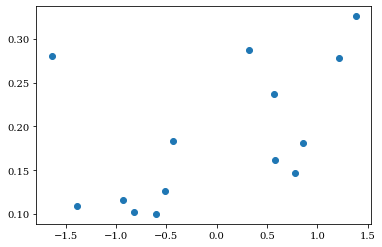

In [516]:
row = df_veg_v15.iloc[idxs]
xvals = row['delta']
yvals = row['V15_cvhFr'] - row['V20_cvhFr']

plt.scatter(xvals,yvals)

In [517]:
row

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,z_change_is_significant,bitstring,median_error,mean_error,variance,label,delta,deltaV20X,deltaV15X,improvement_in_delta
2903,-46.510520,-73.125000,281.607971,4.764214,277.526550,4.171246,278.374756,5.785377,276.373291,5.700918,...,False,0101000,5.232566,5.105439,0.775900,V15,-0.928750,-0.689066,0.008648,-0.239683
2968,-45.948460,-72.750000,281.486603,5.547812,276.183319,5.205066,276.603180,6.122882,275.686249,6.064405,...,False,0101000,5.806108,5.735042,0.437733,V15,-0.817657,-0.413721,0.071169,-0.403937
3462,-42.576096,171.111111,288.086853,1.875457,287.060883,1.745520,287.383301,1.702533,288.777313,1.695013,...,True,0100001,1.724027,1.754631,0.083567,V15,1.214060,0.090301,0.207860,1.123759
19009,-19.812640,44.437500,307.827606,2.698222,307.568054,2.871567,307.079926,3.279350,308.087830,2.432140,...,False,0101000,2.784895,2.820320,0.355399,V15,0.775526,0.746980,0.227382,0.028546
38575,-2.107728,-54.000000,301.163422,3.774287,304.908264,3.848307,304.978271,3.520152,304.621124,2.652650,...,True,0101001,3.647219,3.448849,0.549088,V15,-1.639190,-1.341646,-0.789780,-0.297544
69456,22.903974,-83.400000,301.756317,1.931140,301.974365,1.965086,302.457916,1.906369,302.012512,1.875767,...,True,0101001,1.918755,1.919591,0.037853,V15,0.316146,0.336709,0.009852,-0.020562
89829,34.426218,131.333333,291.155426,2.143995,292.354156,1.968893,292.217255,2.597009,293.446930,2.279860,...,False,0101000,2.211928,2.247439,0.265543,V15,0.563631,0.087785,-0.149361,0.475846
96200,38.079612,139.333333,292.736389,3.737235,290.602203,3.477176,290.992950,3.206824,291.570160,3.143303,...,True,0111001,3.342000,3.391135,0.272384,V15,-0.429878,-0.014047,-0.205906,-0.415831
119618,51.288034,-125.416667,272.708008,4.714465,276.669312,4.687906,276.455933,5.515811,277.626526,3.874488,...,False,0110010,4.701185,4.698167,0.670164,V15,-1.391289,-0.719665,0.349393,-0.671624
120150,51.569065,-126.250000,273.238129,4.145824,275.399261,3.255249,274.738892,3.608855,275.043091,3.571601,...,False,0111010,3.590228,3.645382,0.369425,V15,-0.514464,-0.459353,0.251384,-0.055112


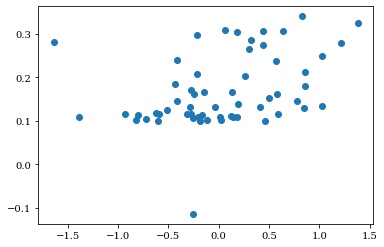

In [388]:
row = df_veg_v15#.iloc[idxs]
xvals = row['delta']
yvals = row['V15_cvhFr'] - row['V20_cvhFr']

plt.scatter(xvals,yvals)

In [365]:
df_veg_v15.columns

Index(['latitude_ERA', 'longitude_ERA', 'MODIS_LST', 'prediction_error_1',
       'prediction_1', 'prediction_error_2', 'prediction_2',
       'prediction_error_3', 'prediction_3', 'prediction_error_4',
       'prediction_4', 'V15_clFr', 'V15_cvhFr', 'V15_cvlFr', 'V15_dl',
       'V15_oceanFr', 'V15_si10Fr', 'V15_z', 'V20_clFr', 'V20_cvhFr',
       'V20_cvlFr', 'V20_dl', 'V20_oceanFr', 'V20_si10Fr', 'V20_z',
       'changeAbs_V20V15_clFr', 'changeAbs_V20V15_cvhFr',
       'changeAbs_V20V15_cvlFr', 'changeAbs_V20V15_oceanFr',
       'changeAbs_V20V15_si10Fr', 'changeAbs_V20V15_dl', 'changeAbs_V20V15_z',
       'clFr_change_is_significant', 'cvhFr_change_is_significant',
       'cvlFr_change_is_significant', 'oceanFr_change_is_significant',
       'si10Fr_change_is_significant', 'dl_change_is_significant',
       'z_change_is_significant', 'bitstring', 'median_error', 'mean_error',
       'variance', 'label', 'delta'],
      dtype='object')

### Glacier

In [463]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/' 
f = f'{root}processed_data/joined_data/2016_MLS.parquet'
training_data = pd.read_parquet(f,columns=['latitude_ERA', 'longitude_ERA','time','number_of_modis_observations'])
num_obs = training_data.groupby(['latitude_ERA','longitude_ERA']).mean().reset_index()
df_glacier_v15 = df_V15.query(glacier_condition)


df_ice_num = pd.merge(df_glacier_v15,num_obs,how='inner',left_on=['latitude_ERA', 'longitude_ERA'], right_on=['latitude_ERA', 'longitude_ERA']) #inner join.



In [464]:
df_ice_num

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,z_change_is_significant,bitstring,median_error,mean_error,variance,label,delta,deltaV20X,deltaV15X,number_of_modis_observations
0,-70.117048,-75.75,256.971741,5.739560,261.956726,5.066422,260.129364,4.930738,259.914642,5.782263,...,True,0001111,5.402991,5.379746,0.443947,V15,-0.308687,-0.374471,-0.260915,9.356383
1,-70.117048,-75.00,256.868408,4.801536,258.348328,5.802318,261.786224,4.479877,257.644714,5.180500,...,False,0001010,4.991018,5.066058,0.568259,V15,-0.535094,-0.226212,-0.296992,8.597403
2,-70.117048,-70.50,255.270554,6.004992,258.368469,5.974317,258.311462,5.864198,258.346069,5.989092,...,False,0001010,5.981704,5.958149,0.063875,V15,0.069508,0.153320,-0.018905,16.005076
3,-70.117048,-69.75,254.160904,6.548598,255.849991,6.080139,257.379974,6.270308,255.777054,6.312194,...,False,0001010,6.291251,6.302810,0.192474,V15,0.178597,0.073198,-0.236420,13.737255
4,-70.117048,-68.25,256.726379,5.350327,258.714355,5.353775,259.090637,5.298773,258.940735,5.451698,...,False,0001010,5.352051,5.363643,0.063866,V15,-0.096608,-0.223717,-0.167809,13.520548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052,70.117048,-27.75,263.331543,4.410246,260.963715,4.632606,261.603363,4.109598,265.143005,4.683808,...,True,1001111,4.521426,4.459064,0.261493,V15,0.048420,0.124455,-0.149116,17.568465
1053,70.117048,-27.00,259.275879,3.593069,260.563080,3.531256,261.564301,3.997893,262.154602,3.525309,...,False,0001110,3.562162,3.661882,0.226093,V15,-0.004075,0.189861,1.020717,16.326446
1054,70.117048,-26.25,258.228577,3.164532,259.698303,3.203387,259.894165,2.989605,258.295410,3.348767,...,False,0001110,3.183959,3.176573,0.147729,V15,0.475860,0.683858,0.442715,18.762115
1055,70.117048,-25.50,255.390076,3.870412,257.871735,4.061967,258.024048,3.492034,256.961609,4.352198,...,False,0001010,3.966189,3.944153,0.360661,V15,0.438827,0.282141,0.221607,17.168776


In [466]:
many = df_ice_num.query('number_of_modis_observations > 50')

n=10
df10 = many.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta']])



,latitude_ERA,longitude_ERA,delta
539,34.988278,75.666667,1.547314
443,-33.021066,-70.080000,1.257519
447,-32.177975,-70.080000,1.187067
511,32.740036,77.760000,1.125697
440,-33.864157,-69.760000,1.042520
439,-34.145187,-69.760000,0.956463
251,-66.744690,140.666667,0.922475
360,-64.215421,-57.500000,0.836911
964,67.868810,-66.240000,0.629654
368,-63.653361,-58.800000,0.623002


In [472]:
row = many.sort_values(by=['delta'],ascending=False).iloc[2]
display(row)
print("Coords:", row.latitude_ERA,row.longitude_ERA)

latitude_ERA                       -32.177975
longitude_ERA                          -70.08
MODIS_LST                          293.646423
prediction_error_1                   4.271501
prediction_1                       291.819153
prediction_error_2                   5.252614
prediction_2                       289.942719
prediction_error_3                   4.288364
prediction_3                       291.879639
prediction_error_4                   4.617187
prediction_4                       291.368774
V15_clFr                                  0.0
V15_cvhFr                            0.014069
V15_cvlFr                            0.368976
V15_dl                                   25.0
V15_oceanFr                               0.0
V15_si10Fr                                0.0
V15_z                            39893.121094
V20_clFr                             0.007635
V20_cvhFr                              0.0124
V20_cvlFr                            0.325216
V20_dl                            

Coords: -32.177974963981924 -70.07999999999998


In [449]:
df_glacier_v15 = df_V15.query(glacier_condition)
n=20
df10 = df_glacier_v15.sort_values(by=['delta'],ascending=False).iloc[0:n]
display(df10[['latitude_ERA','longitude_ERA','delta']])

,latitude_ERA,longitude_ERA,delta
2328,-54.098337,-36.900000,2.573259
2797,-47.634641,-72.400000,2.494534
2632,-49.601853,68.750000,2.286490
2659,-49.320823,69.166667,1.970708
2119,-65.339540,-61.875000,1.683147
89218,34.145187,76.480000,1.638144
90646,34.988278,75.666667,1.547314
90163,34.707248,76.666667,1.475624
2174,-63.934391,-58.200000,1.459995
30091,-9.133487,-77.625000,1.388260


In [524]:
i = 0



names = ['Calluqueo Glacier',
'juncal Glacier']

 

 
calluqueo_condition = 'latitude_ERA == -47.63464127942677 & longitude_ERA ==  -72.39999999999998'
juncal_condition = 'latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998'


glacier_idx_conditions = [calluqueo_condition,juncal_condition]

for c in glacier_idx_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    

Calluqueo Glacier
Summary statistics: 1 || 0.384 0.622 1.599 0.734 || 0.078 2.495 0.324
Change is  Insignificant
juncal Glacier
Summary statistics: 1 || 0.675 0.294 1.061 0.359 || 0.107 1.258 1.196
Change is  Insignificant


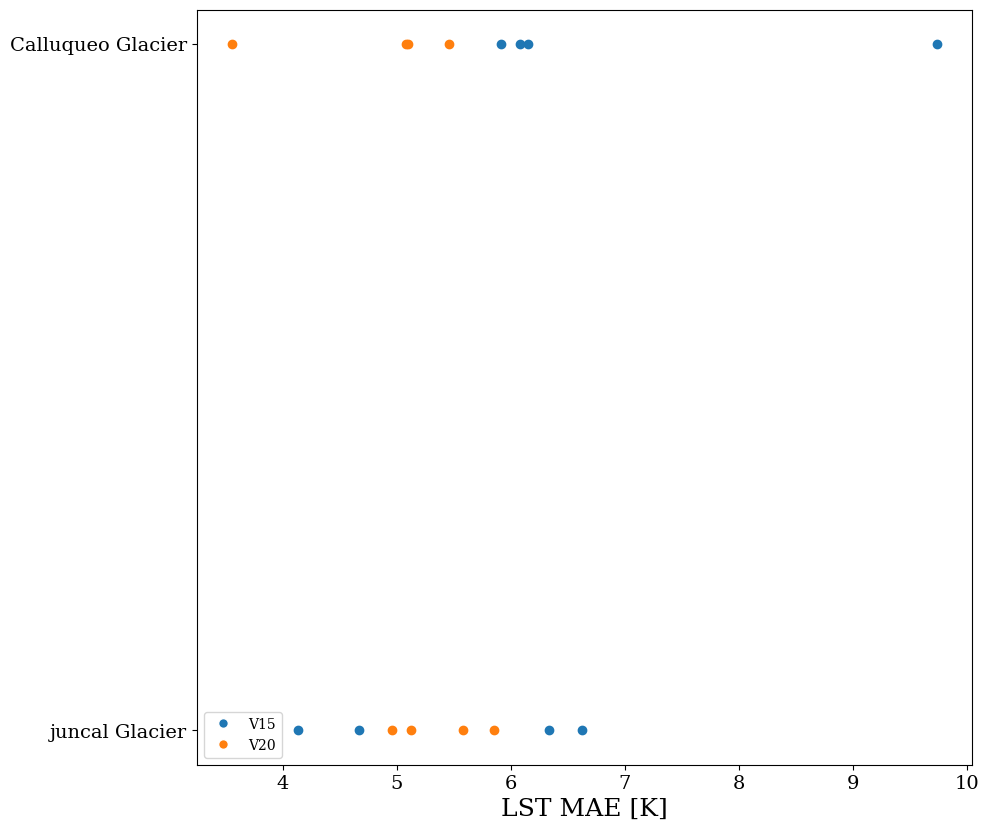

In [526]:
shift_plot(df_V20,df_V20X,glacier_idx_conditions,names,savefig=None)

In [456]:
# 1 - Calluqueo Glacier

In [462]:
row = df_glacier_v15.sort_values(by=['delta'],ascending=False).iloc[4]
display(row)
print("Coords:", row.latitude_ERA,row.longitude_ERA)


latitude_ERA                      -65.33954
longitude_ERA                       -61.875
MODIS_LST                        255.527939
prediction_error_1                 5.987214
prediction_1                      255.06311
prediction_error_2                 5.141031
prediction_2                     255.390808
prediction_error_3                 5.220895
prediction_3                      256.17688
prediction_error_4                 4.685099
prediction_4                     257.833282
V15_clFr                                0.0
V15_cvhFr                               0.0
V15_cvlFr                               0.0
V15_dl                                 25.0
V15_oceanFr                             0.0
V15_si10Fr                         0.350403
V15_z                            538.499878
V20_clFr                           0.000039
V20_cvhFr                               0.0
V20_cvlFr                               0.0
V20_dl                                 10.0
V20_oceanFr                     

Coords: -65.33954042910749 -61.875


In [452]:
juncal_condition = 'latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998'
df_glacier_v15.query(juncal_condition).iloc[0]

latitude_ERA                       -33.021066
longitude_ERA                          -70.08
MODIS_LST                          290.502838
prediction_error_1                   4.377077
prediction_1                       289.279449
prediction_error_2                   3.396034
prediction_2                       289.043396
prediction_error_3                   3.773364
prediction_3                       289.165131
prediction_error_4                   5.182201
prediction_4                       287.491852
V15_clFr                             0.002379
V15_cvhFr                                 0.0
V15_cvlFr                            0.053761
V15_dl                              23.639648
V15_oceanFr                               0.0
V15_si10Fr                                0.0
V15_z                            39204.597656
V20_clFr                             0.001695
V20_cvhFr                                 0.0
V20_cvlFr                            0.040329
V20_dl                            

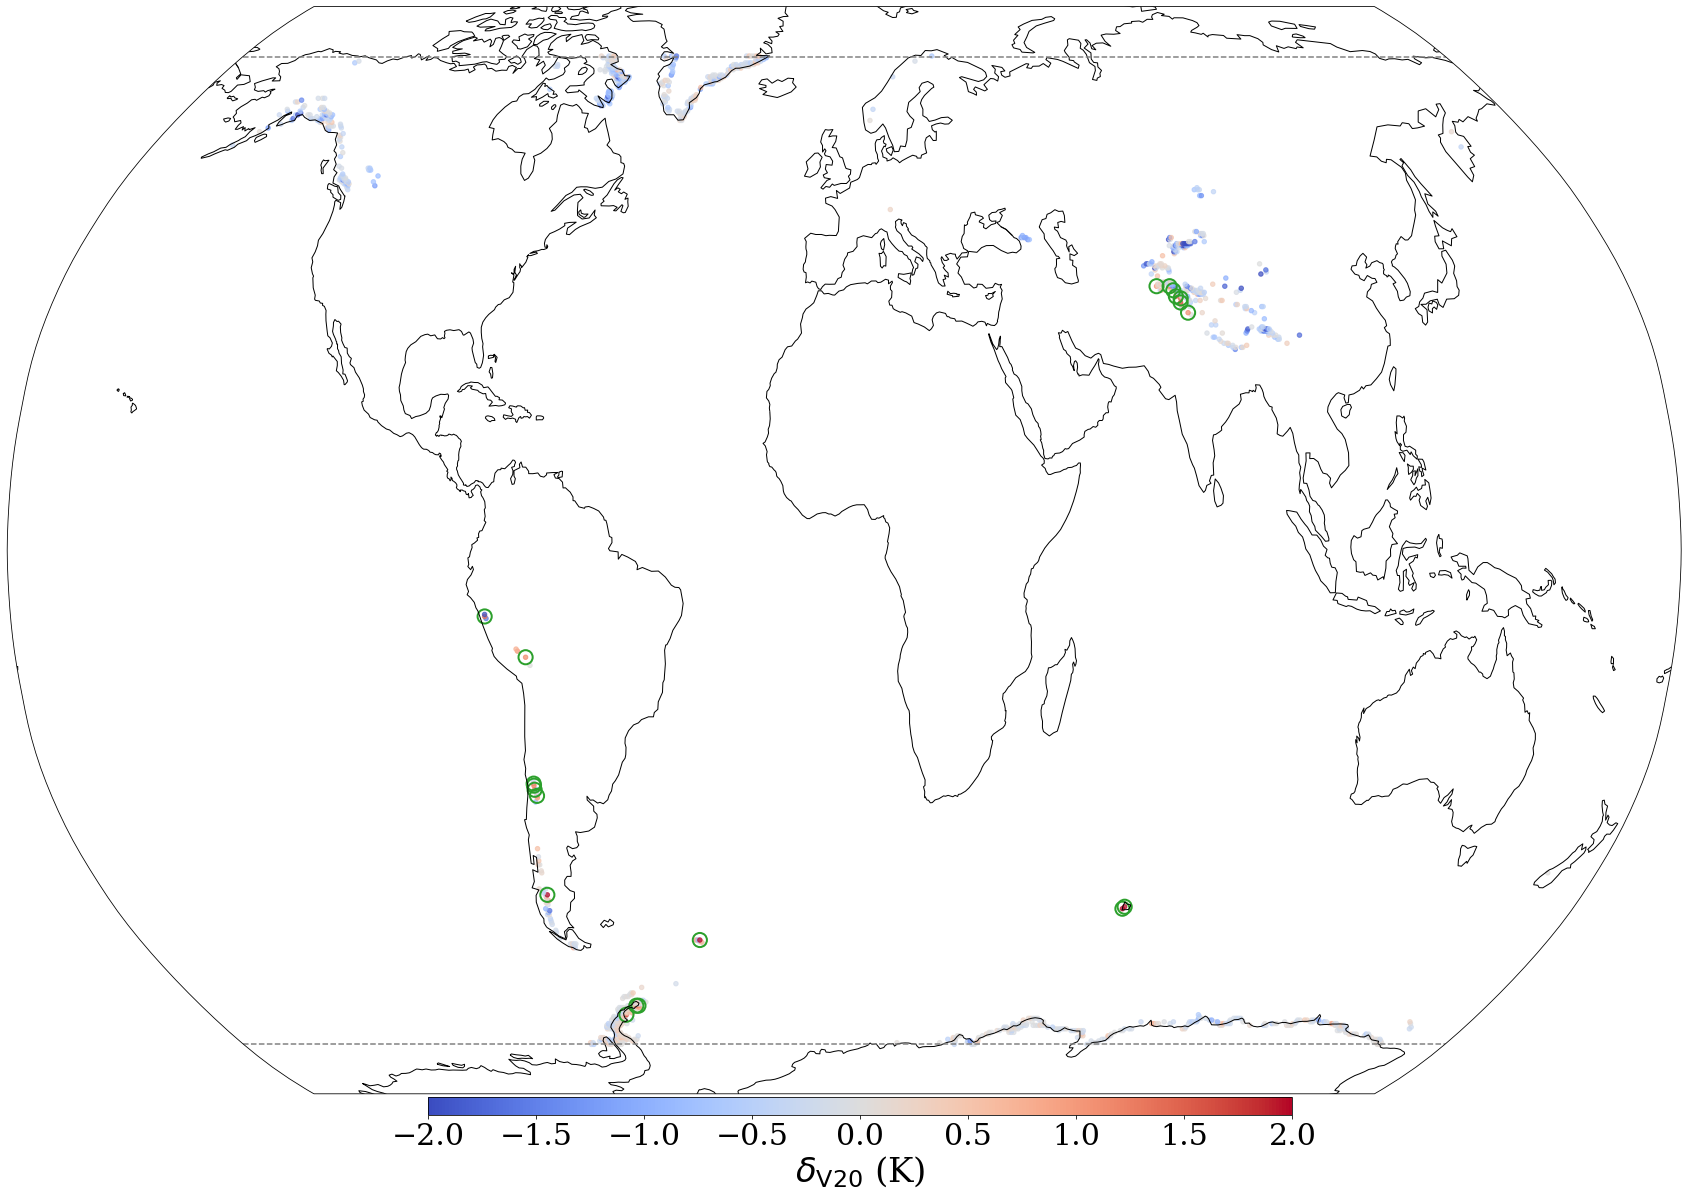

In [450]:
RobinsonPlot(df_glacier_v15,'delta',vmin=-2,vmax=+2,cmap=plt.cm.coolwarm,markersize = 20,savefig='updated_glacier_plot',ncircles=n)


In [378]:
df_glacier_v15.query(juncal_glacier_condition)

,latitude_ERA,longitude_ERA,MODIS_LST,prediction_error_1,prediction_1,prediction_error_2,prediction_2,prediction_error_3,prediction_3,prediction_error_4,...,oceanFr_change_is_significant,si10Fr_change_is_significant,dl_change_is_significant,z_change_is_significant,bitstring,median_error,mean_error,variance,label,delta
6228,-33.021066,-70.08,290.502838,4.377077,289.279449,3.396034,289.043396,3.773364,289.165131,5.182201,...,False,True,True,False,0001010,4.075221,4.182169,0.779569,V15,1.257519
